#**An Analysis on Horse Health**

> Dataset: https://www.kaggle.com/competitions/playground-series-s3e22/data?select=train.csv


> This Kaggle challenge is to accuractely predict the health outcome of horses, based on various medical indicators. We are expected to use different machine learning algorithms to make predicitons from the given data.


> We are given a tabular dataset. It has various columns that describe the horse's state of health. Columns include: age, if they've had surgery, pulse, respiratory rate, and more.





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from tabulate import tabulate

## **Data Loading and Initial Look**

In [2]:
# loading the data
data = pd.read_csv("train.csv")
data.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [3]:
# counting # of rows and columns
print(data.shape)

(1235, 29)


In [4]:
#checking for missing values
for i in data.columns:
  if data[i].isna().sum() > 0:
    print(f'The {i} column has {data[i].isna().sum()} missing values')

The temp_of_extremities column has 39 missing values
The peripheral_pulse column has 60 missing values
The mucous_membrane column has 21 missing values
The capillary_refill_time column has 6 missing values
The pain column has 44 missing values
The peristalsis column has 20 missing values
The abdominal_distention column has 23 missing values
The nasogastric_tube column has 80 missing values
The nasogastric_reflux column has 21 missing values
The rectal_exam_feces column has 190 missing values
The abdomen column has 213 missing values
The abdomo_appearance column has 48 missing values


In [5]:
types = []
for i in data.columns:
  types.append(data[i].dtype)
print(set(types))

{dtype('int64'), dtype('float64'), dtype('O')}


In [6]:
# creating table w/ info of each feature
# need to include : numeric or catergorical,range of vals,unique vals, missing vals, outliers

def analyze_dataset(data):
    feature_summary = [] # creating list so we can input it into tabulate

    def detect_outliers(column):
        if column.dtype.kind in 'if': # i is int, f is float, only need these 2
            q1 = column.quantile(0.25)
            q3 = column.quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers = column[(column < lower_bound) | (column > upper_bound)]  #findind the outliers in the columns
            return len(outliers), f"Outliers outside range [{lower_bound: .2f}, {upper_bound: .2f}]" #returning quantity and contents
        return 0, "N/A for categorical"

    for i in data.columns:
        feature_type = "Categorical" if data[i].dtype == 'object' else "Numerical"
        unique_values = (
            ", ".join(map(str, data[i].dropna().unique())) + "..."  # Limit to first 10 values
            if feature_type == "Categorical"
            else "N/A"
        )
        value_range = (
            f"[{data[i].min(): .2f}, {data[i].max(): .2f}]" if feature_type == "Numerical" else "N/A"
        )
        missing_values = data[i].isna().sum()
        outliers_count, outlier_def = detect_outliers(data[i])

        # Append information to the summary
        feature_summary.append([
            i,
            feature_type,
            unique_values if feature_type == "Categorical" else value_range,
            missing_values,
            outliers_count,
            outlier_def
        ])

    # creating the table
    return tabulate(
        feature_summary,
        headers=["Column Name", "Type", "Values/Range", "Missing Values", "Outliers", "Outlier Definition"],
        tablefmt="fancy_grid"
    )

# calling func with dataset
info_table = analyze_dataset(data)
print(info_table)


╒═══════════════════════╤═════════════╤══════════════════════════════════════════════════════════════════════════════════╤══════════════════╤════════════╤═════════════════════════════════════════════════╕
│ Column Name           │ Type        │ Values/Range                                                                     │   Missing Values │   Outliers │ Outlier Definition                              │
╞═══════════════════════╪═════════════╪══════════════════════════════════════════════════════════════════════════════════╪══════════════════╪════════════╪═════════════════════════════════════════════════╡
│ id                    │ Numerical   │ [ 0.00,  1234.00]                                                                │                0 │          0 │ Outliers outside range [-617.00,  1851.00]      │
├───────────────────────┼─────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────┼────────────┼──────────────────────────

In [7]:
# checking the split of the features
obj = 0
num = -1 # bc i dont want to count the id column cos its useless
for i in data.columns:
  if data[i].dtype == 'object':
    obj +=1
  else:
    num +=1
print(f'There are {obj} categorical features and {num} numerical features')


There are 17 categorical features and 11 numerical features


In [8]:
# checking for class imbalance
dist = data['outcome'].value_counts()
distpercent = (dist/dist.sum() * 100).round()
combined_info = dist.astype(str) + ' (' + distpercent.astype(str) + '%)'

print(combined_info)

outcome
lived         574 (46.0%)
died          410 (33.0%)
euthanized    251 (20.0%)
Name: count, dtype: object


> The percentages are relatively similar. I don't plan to balance them, but if my models don't perform well, that might be an indicator that I should.



## **Data Visualization**

In [9]:
numeric_cols = []
for i in data.columns:
  if data[i].dtype != 'object' and i != 'id': # dont need id for histograms
    numeric_cols.append(i)

print(numeric_cols)

['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']


In [10]:
for i in numeric_cols:
  print(f'{i} has {data[i].nunique()} unique values')
  print(data[i].unique())
  print()

hospital_number has 255 unique values
[ 530001  533836  529812 5262541 5299629  529642  534787  529461  528742
  529640  528682  530028  528548  528134  528305  534885 5290482 5279822
  533692  535208  528523  529893  534145  530233  529399  530354  528503
  529796  527916  530360  528298  533871  529388  527563  534163  529827
  535196  535176  529045  527518  527463  529172  528996  533887  528904
  535407  533902  523190  534073  534135 5290409  529160  534917  534784
 5299253  534004  534115  529667 5297159  529427  527677  530612  535415
  530561  530242  530002 5289419  529498  529126 5291409 5287179  530526
 5290759  532110  534293  534280  528214  527933 5283431  528743  529766
  529304  530401  527702  529849  534157  534998  529340  530276  527927
  534886  527365  528641  528461  528469  529607  533942  529272  528183
  533696  528247  535043  530034  534925  530402  535292  529493  528355
  534197  530239  529777  530478  534069  533928  528570  528800  528668
  530693  528

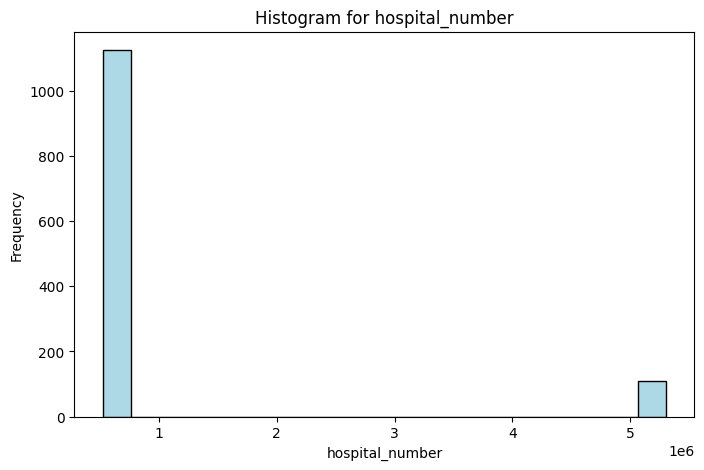

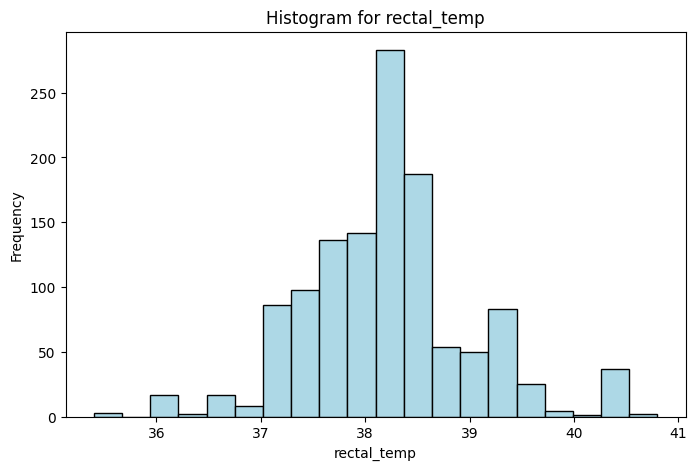

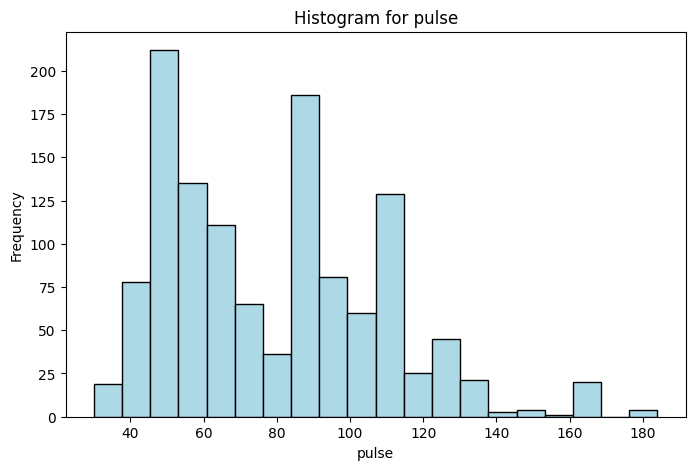

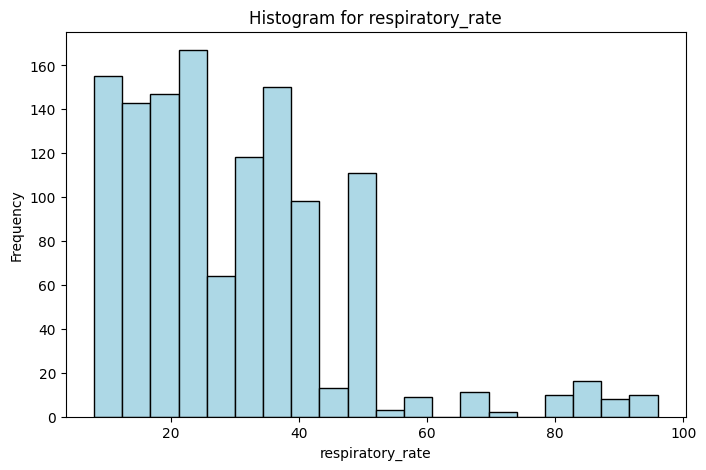

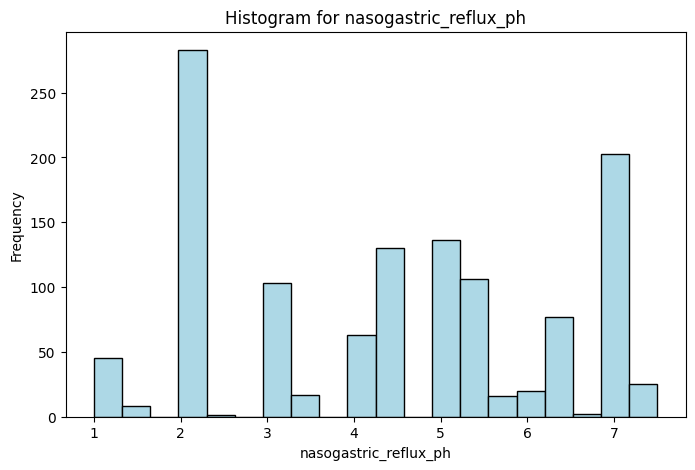

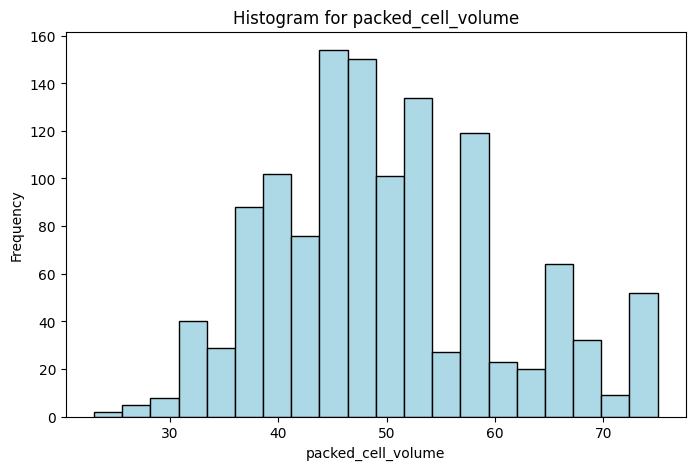

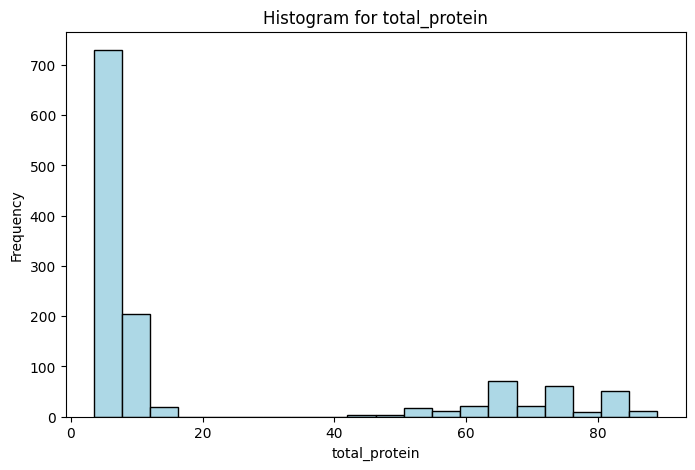

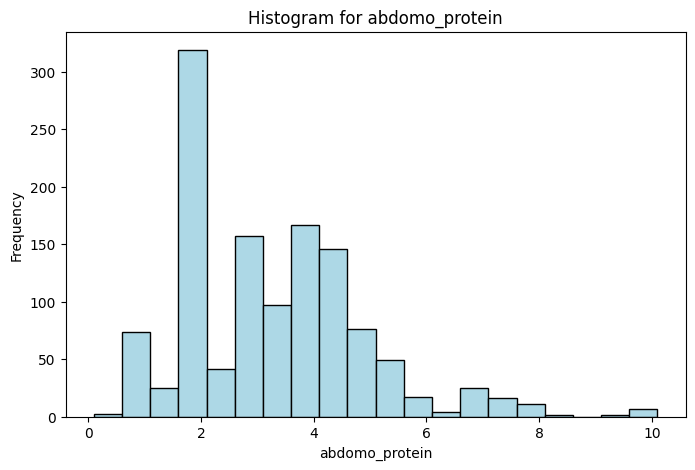

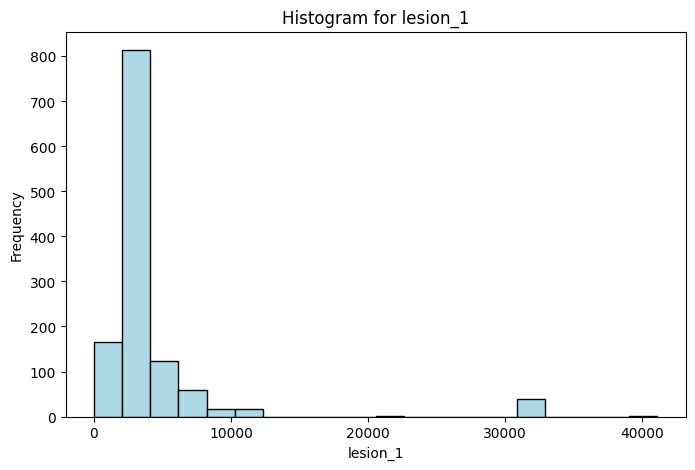

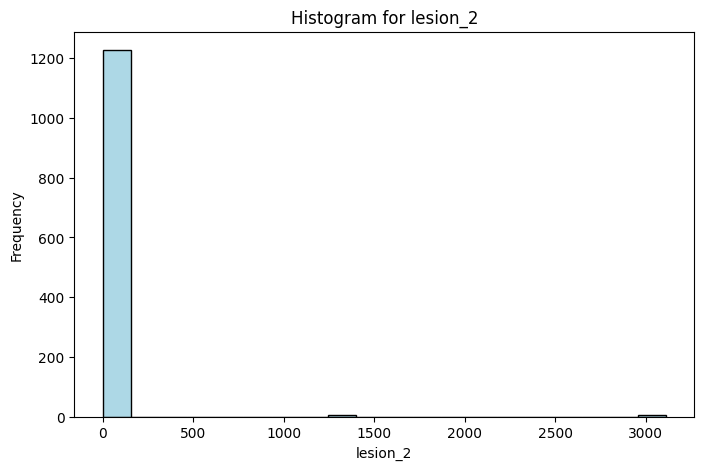

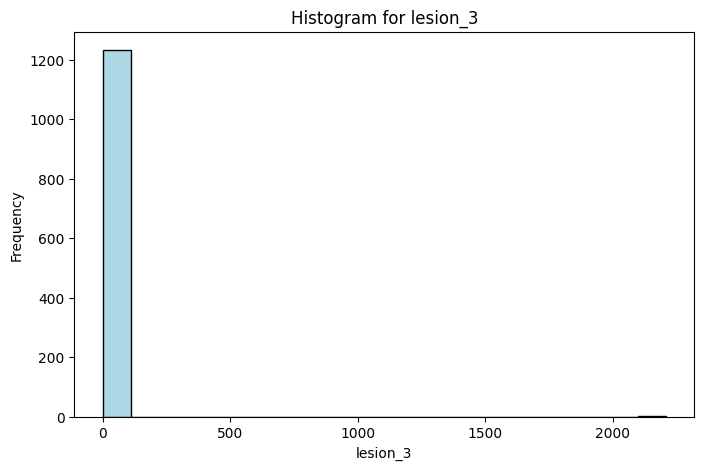

In [11]:
for i in numeric_cols:
  plt.figure(figsize=(8, 5))
  plt.hist(data[i].dropna(), bins=20, color='lightblue', edgecolor='black')  # Drop NaN for plotting
  plt.title(f'Histogram for {i}')
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.show()

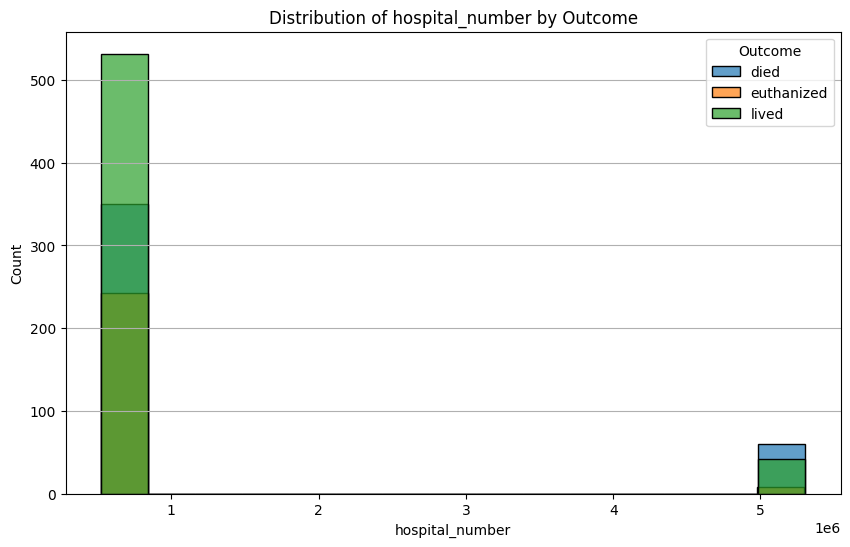

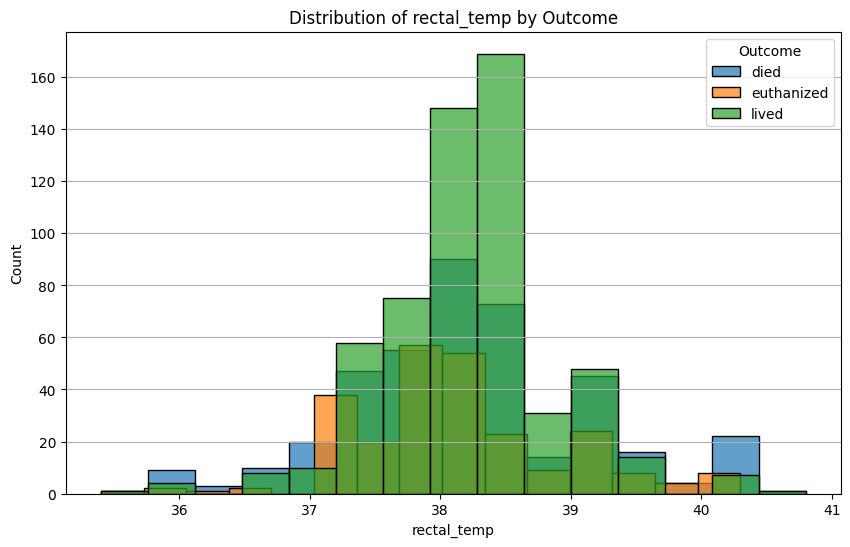

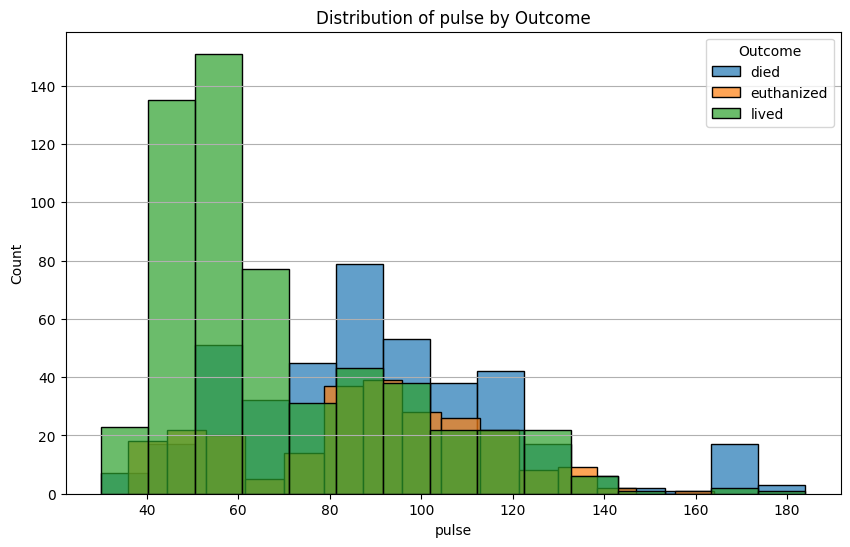

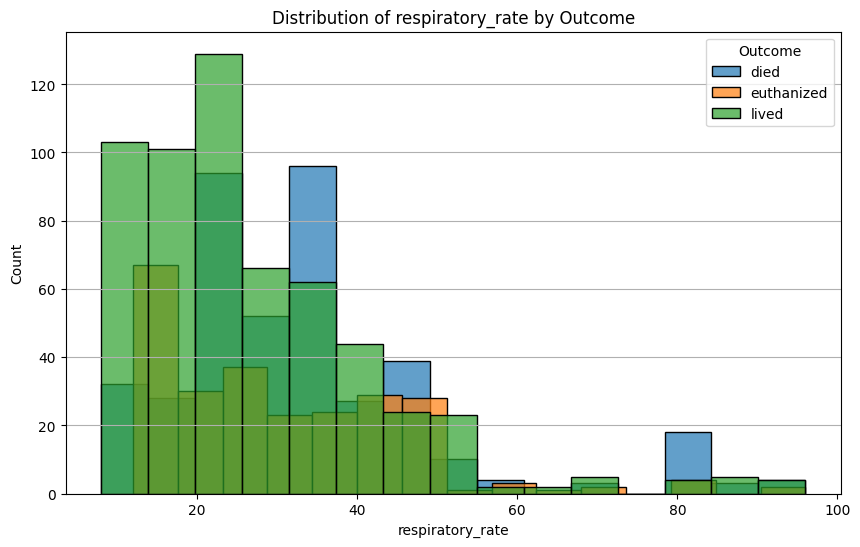

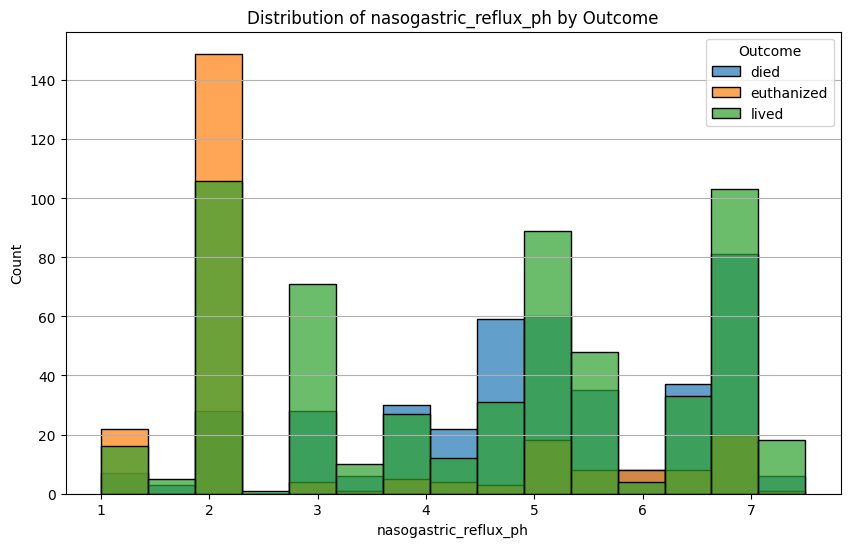

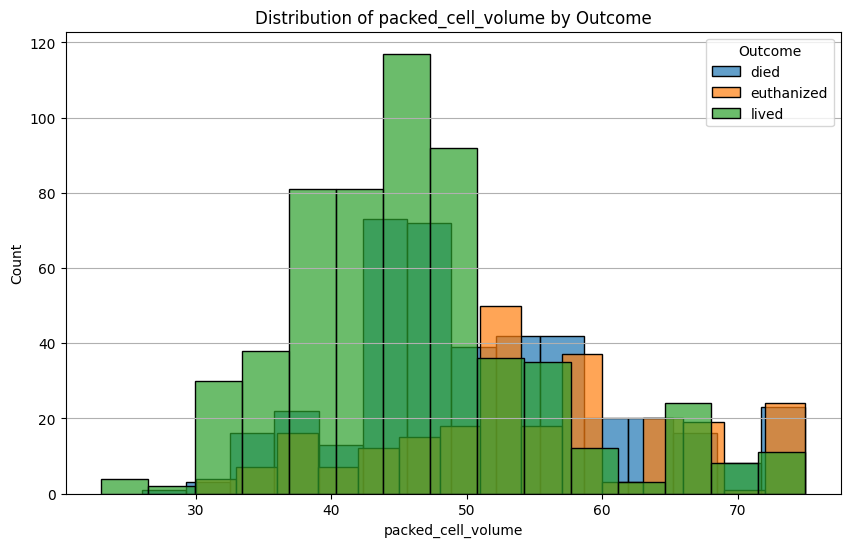

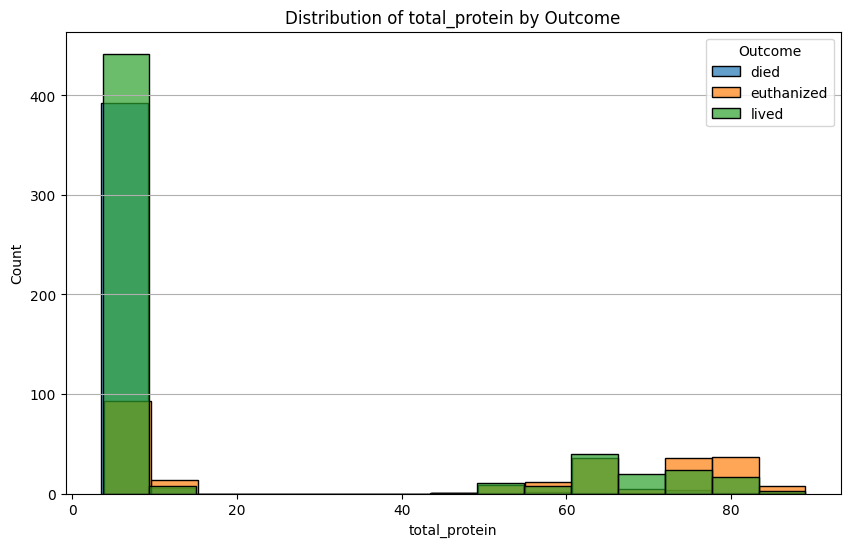

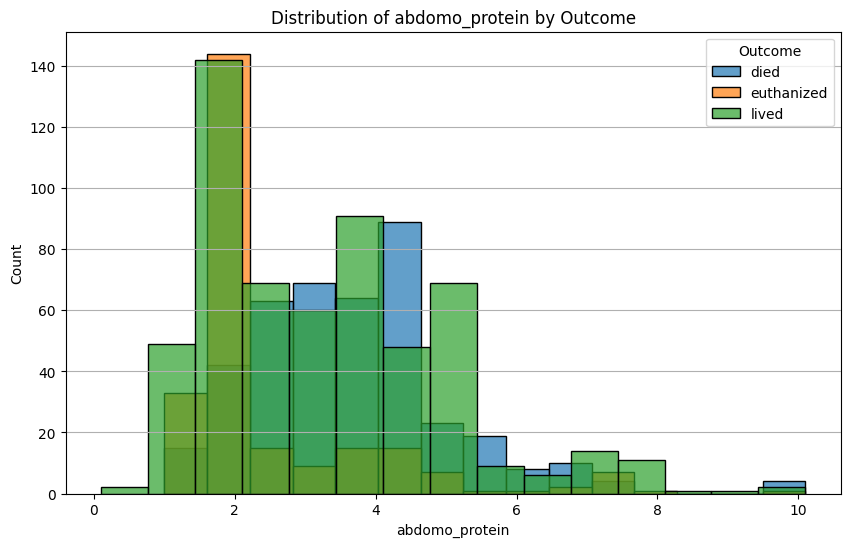

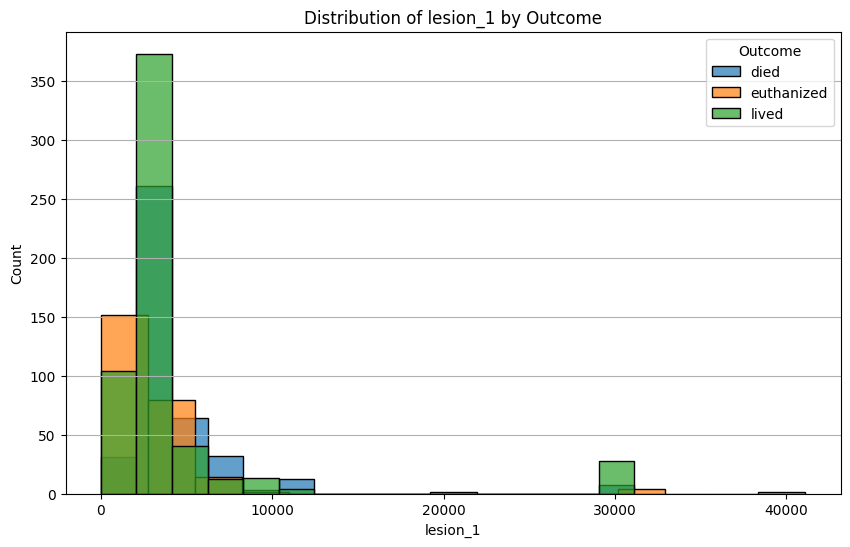

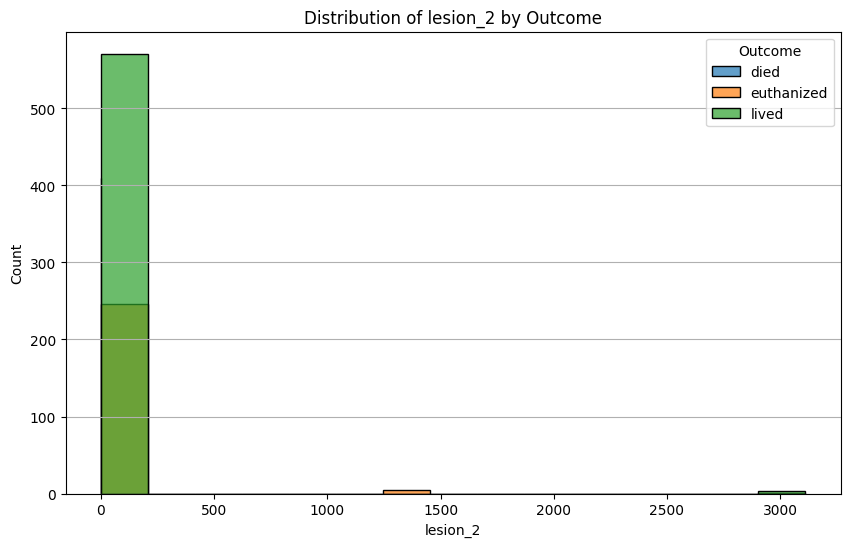

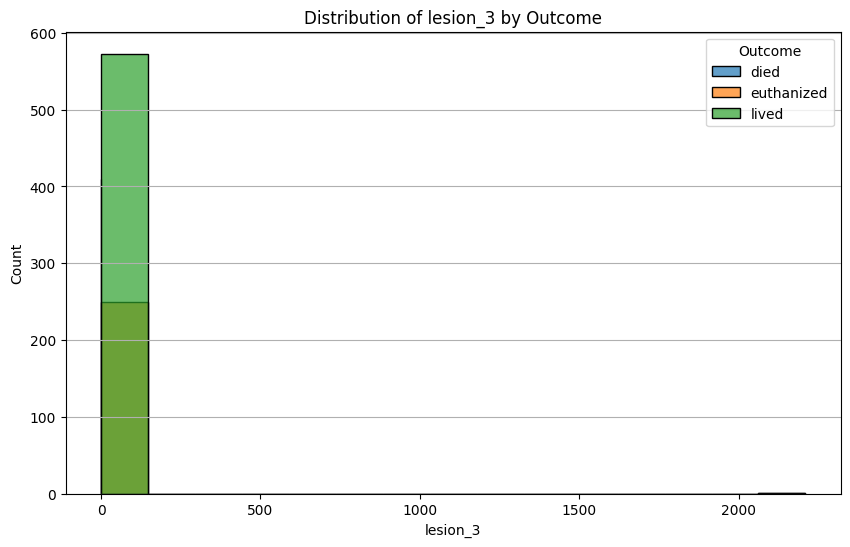

In [12]:
# here im relating to the outcomes to the already created histrograms for the numeric features

for i in numeric_cols:
    plt.figure(figsize=(10, 6))

    # including the lived, died, and euthanized outcomes
    for j in data['outcome'].unique():
        subset = data[data['outcome'] == j]
        sns.histplot(subset[i], kde=False, label=j, bins=15, alpha=0.7)

    # aesthetics
    plt.title(f"Distribution of {i} by Outcome")
    plt.xlabel(i)
    plt.ylabel("Count")
    plt.legend(title="Outcome")
    plt.grid(axis='y')
    plt.show()

###These graphs are a little hard to read because of all the overlap happening so lets create some boxplots and violin plots to we can actually see whats happening...

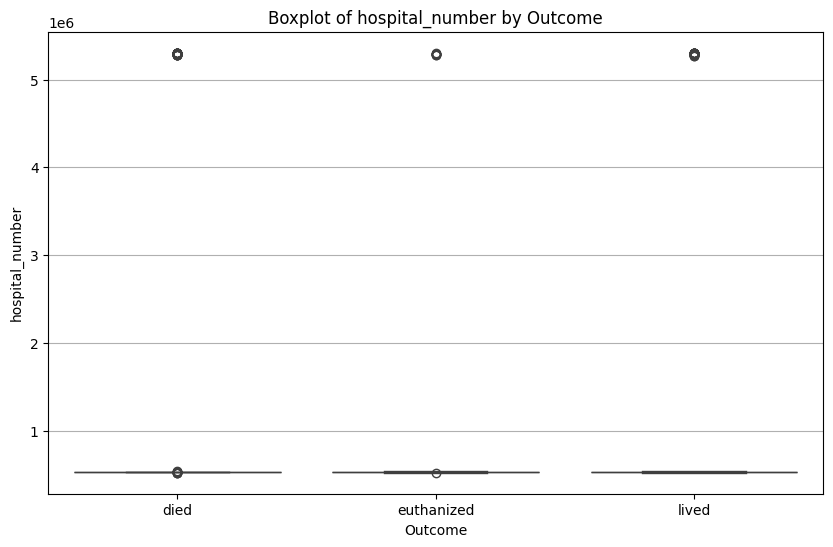

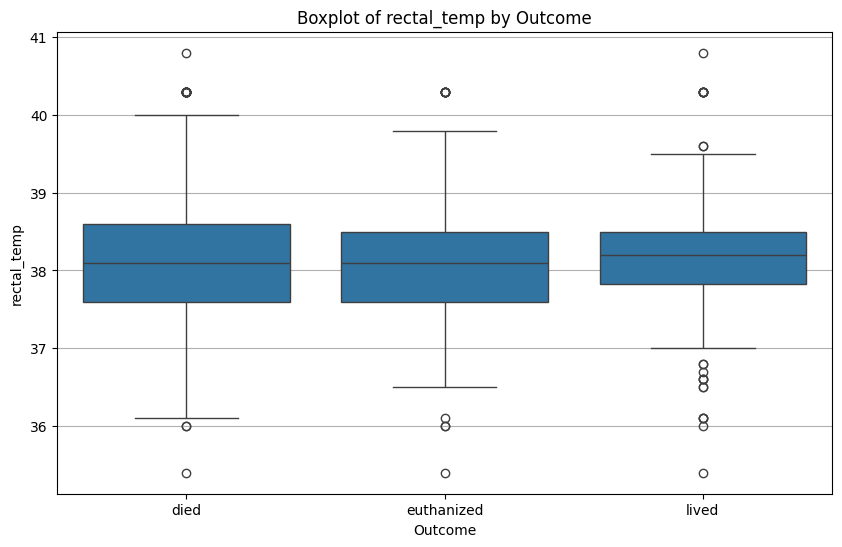

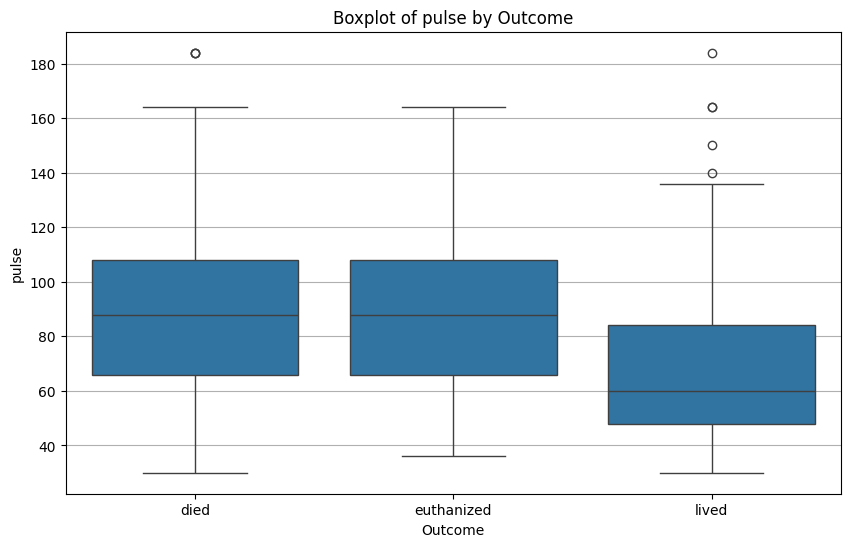

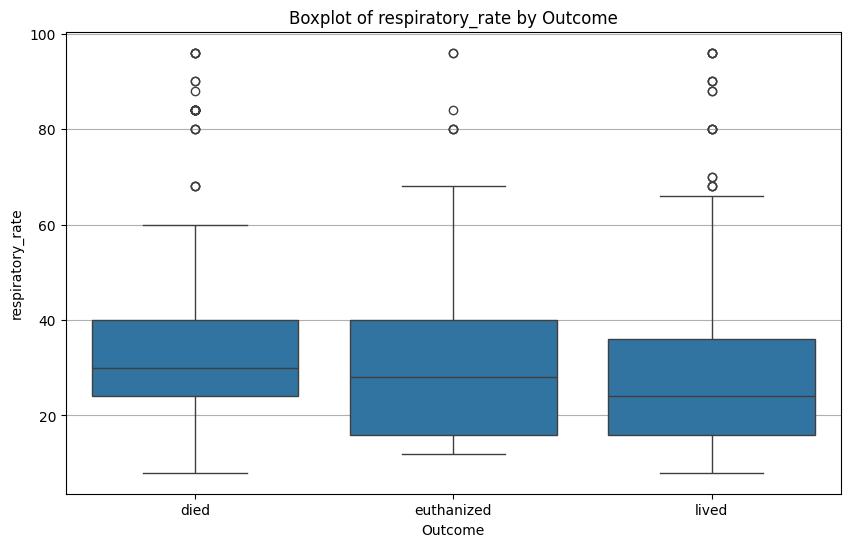

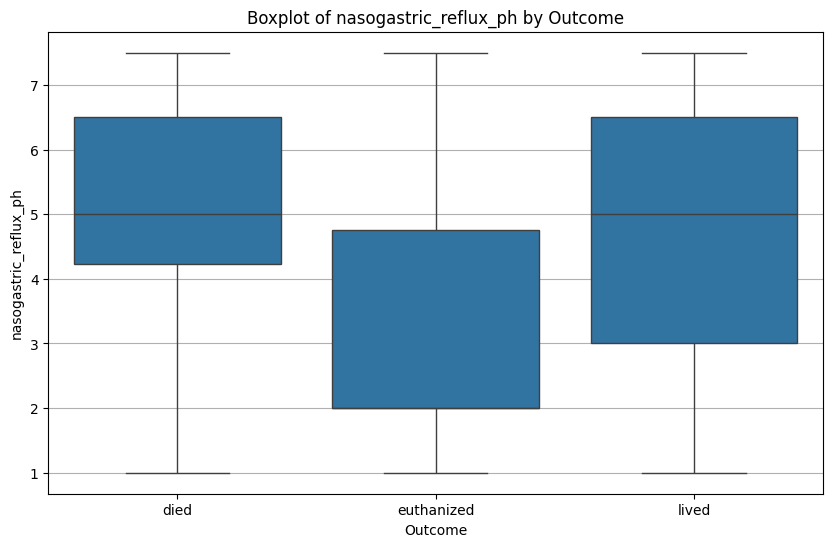

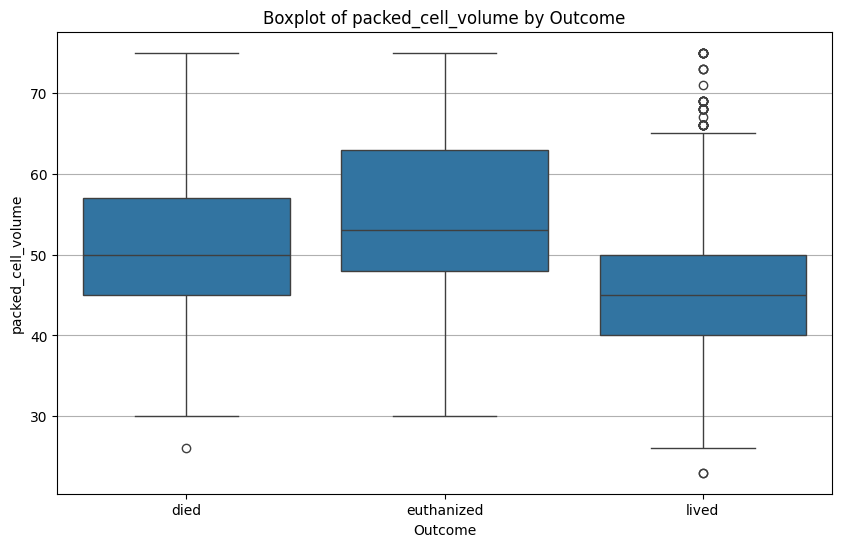

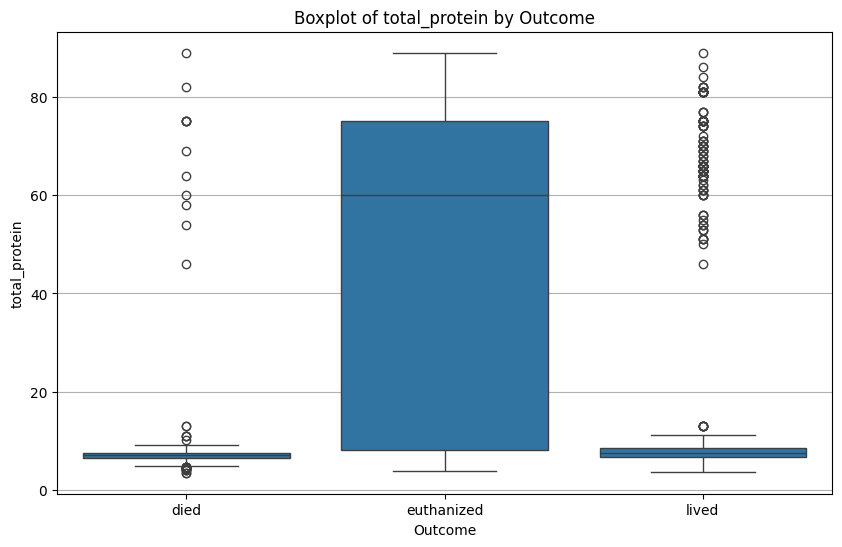

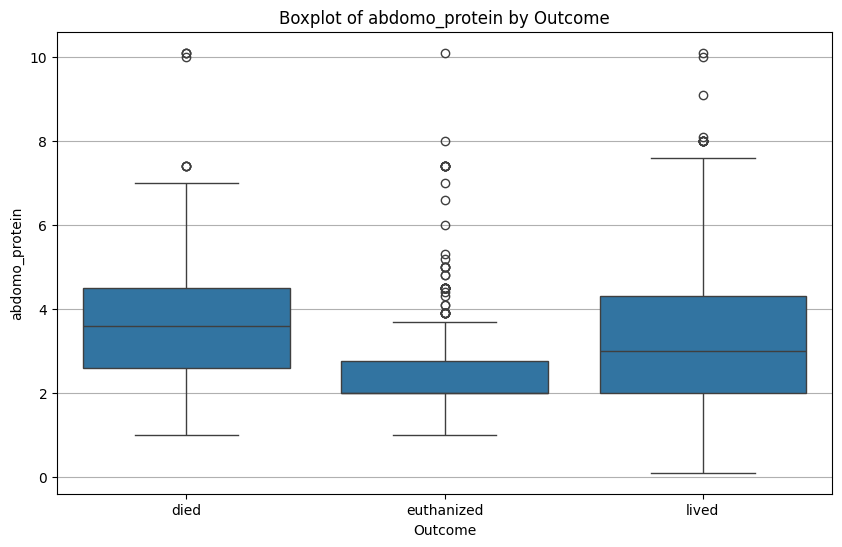

In [ ]:
# here i created boxplots relating the numeric features to the outcomes
for feature in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='outcome', y=feature, data=data)
    plt.title(f"Boxplot of {feature} by Outcome")
    plt.xlabel("Outcome")
    plt.ylabel(feature)
    plt.grid(axis='y')
    plt.show()


<ipython-input-14-52e8297edb55>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")


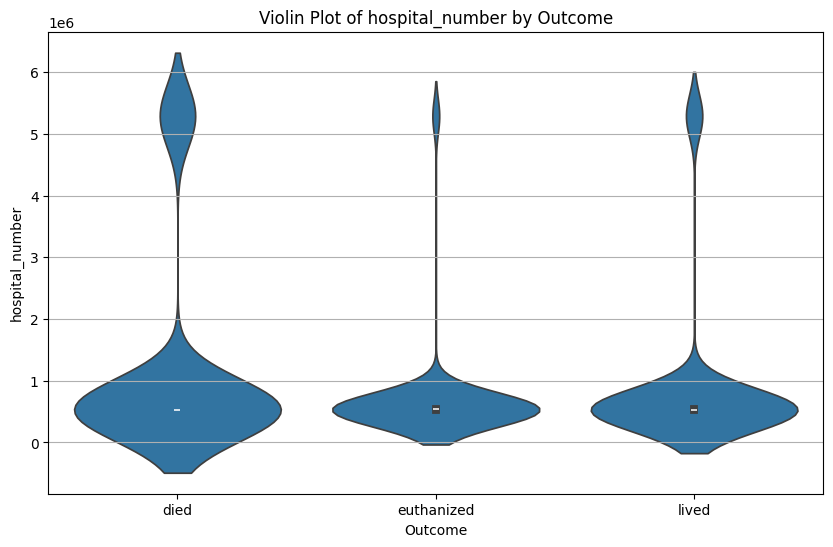

<ipython-input-14-52e8297edb55>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")


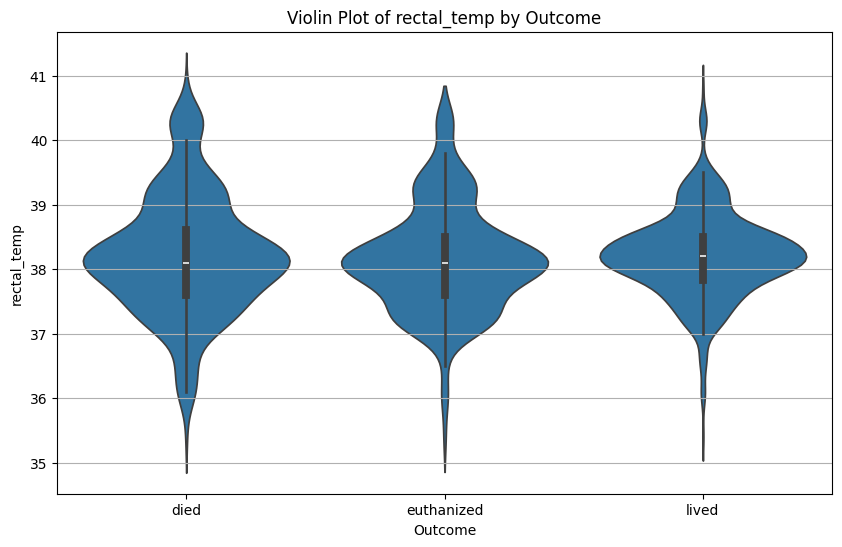

<ipython-input-14-52e8297edb55>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")


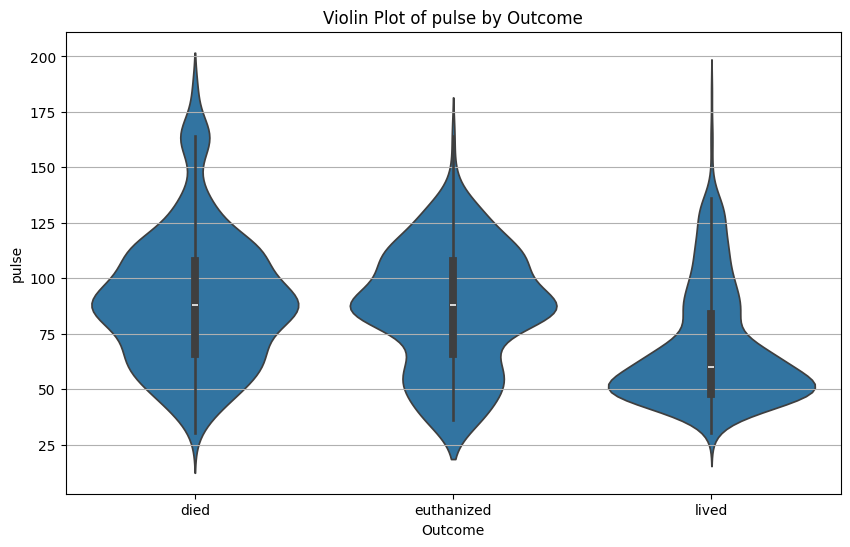

<ipython-input-14-52e8297edb55>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")


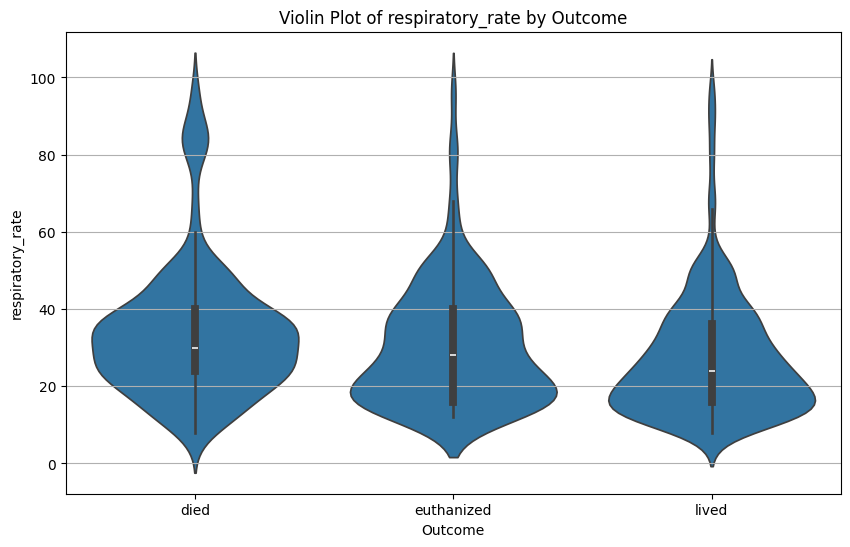

<ipython-input-14-52e8297edb55>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")


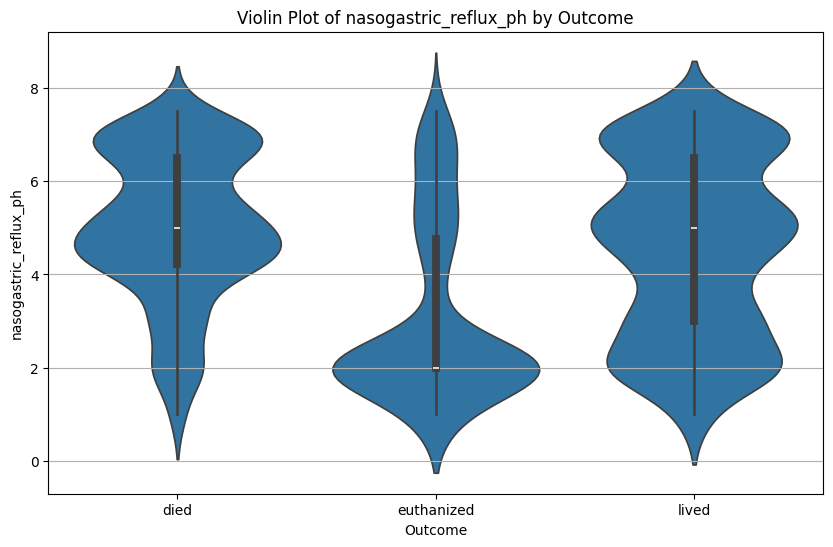

<ipython-input-14-52e8297edb55>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")


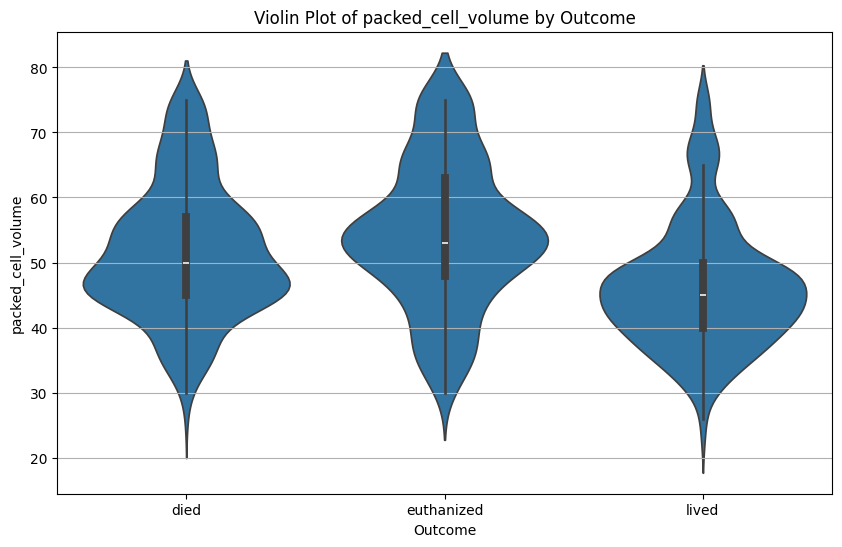

<ipython-input-14-52e8297edb55>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")


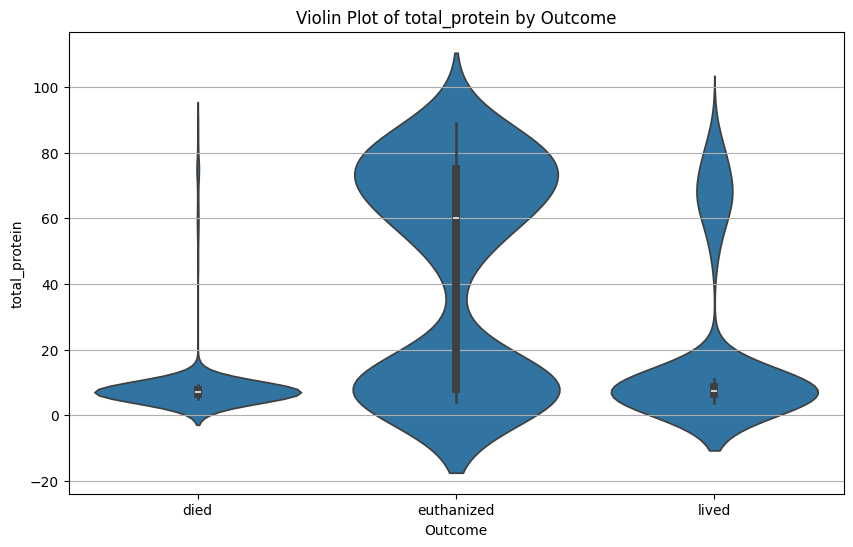

<ipython-input-14-52e8297edb55>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")


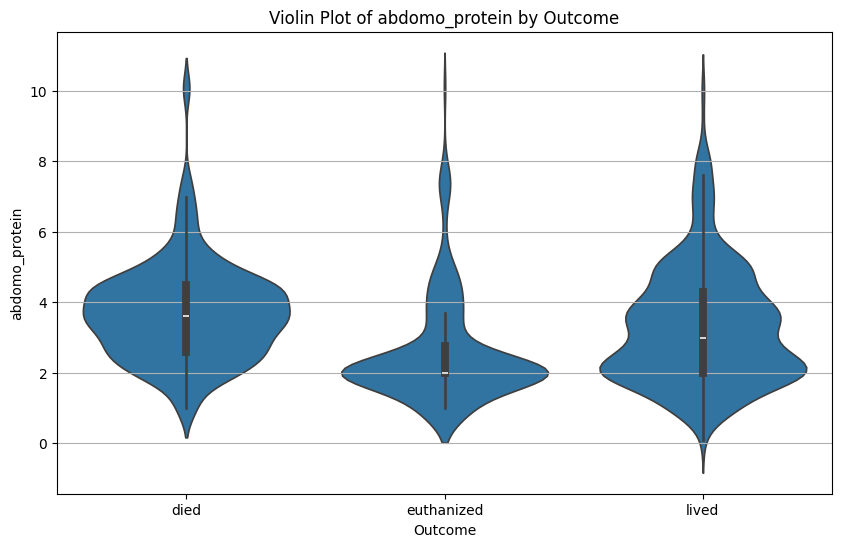

<ipython-input-14-52e8297edb55>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")


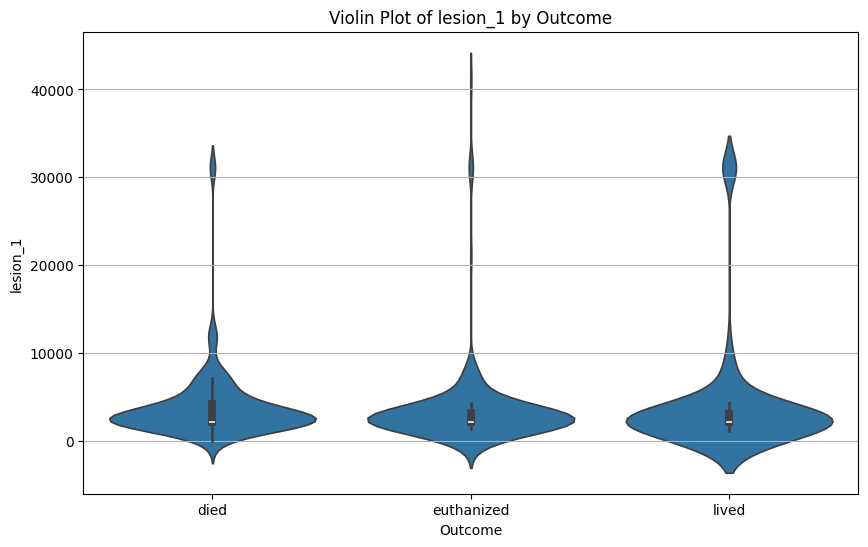

<ipython-input-14-52e8297edb55>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")


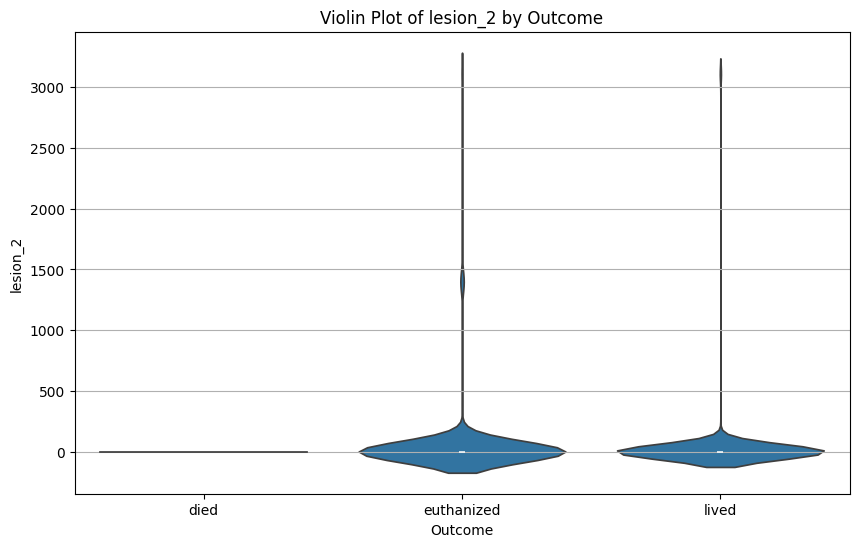

<ipython-input-14-52e8297edb55>:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")


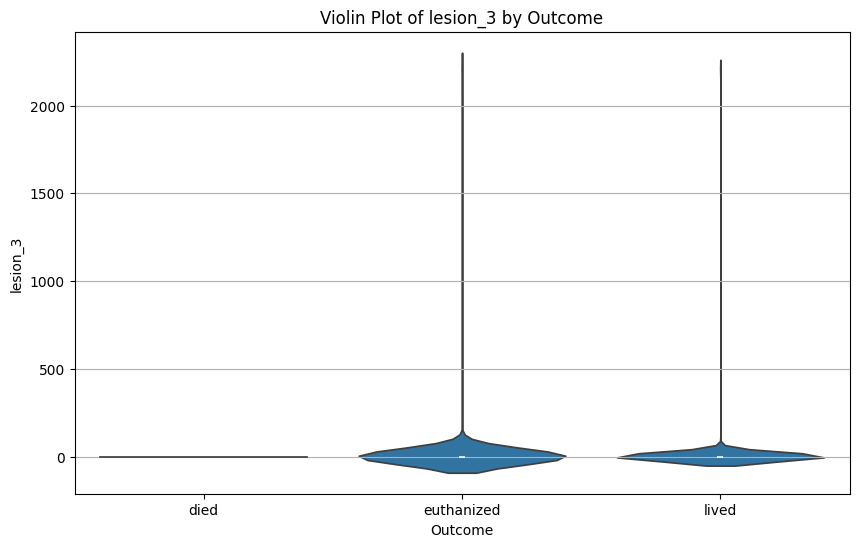

In [14]:
# here i created violin plots relating the numeric features to the outcomes
for feature in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='outcome', y=feature, data=data, inner="box", scale="width")
    plt.title(f"Violin Plot of {feature} by Outcome")
    plt.xlabel("Outcome")
    plt.ylabel(feature)
    plt.grid(axis='y')
    plt.show()

##Interpretting the Violin plots...

###**Hospital Number:**
minimal distinction between outcome classes so it probably wont significatnlly contribute to model. **NOT USEFUL**

###**Rectal Temp:**
horses that lived showed more concentrated temp around 38 degress. Higher temps are slightly more frequent in horses that died or were euthanized. **USEFUL**

###**Pulse:**
This feature is a strong candidate for classfication because of its clear distinction. Horses that lived has lower pulses, usually below 80. Horses that died or were euthanized tended to have higher pulses, with many recordings exceeding 100 **USEFUL**

###**Respiratory Rate:**
Horses that lived tended to have lower repiratory rates, usually below 30. Horses that were euthanized had slightlt more instances of higher respiratory rates, and horses that died had alot more instances of highers repiratory rates (above 40). Also, there may be some outliers in the died outcome.**USEFUL**

###**Nasogastric Reflux PH:**
This feature may not be the most useful becase there is a wide spread of pH values present in all outcomes. Horses that lives showed a wider distribution and horses that were euthanized tended to cluster around the values 2-3. **LITTLE USEFUL**

###**Packed Cell Volume:**
This is a strong candidate aswell. The majority of horses that lived had packed cell volumes between 40-50. Horses that died tended to have higher volumes (>60). Horses that were euthanized also had alot more higher volumes. **USEFUL**

###**Total Protein:**
This may not be a strong candidate. There is little seperation between outcomes. Horses that lived, died, and were euthanized all were concentrated around 15. Interestinly enough, horses that were euthanized had quite of few instances of really high protein. **NOT USEFUL**

###**Abdomo Protein:**
Horses that lived tended to have values concentrated around 2-4, with quite a few instances of higher protein levels. Values more than 6 are slightly more associated with horses that died. The majority of horses that were euthanized had their protein around 2. This feature could be a moderate predictor. **LITTLE USEFUL**

###**Lesion 1:**
The majority of the values are concentrated near zero for all outcomes. There is minimal separation between classes, suggesting this feature will probably not be useful for the model. **NOT USEFUL**

###**Lesion 2:**
There is no clear differentiation across outcomes.
This feature is unlikely to be useful. **NOT USEFUL**

###**Lesion 3:**
Again, there is no clear seperation for the outcomes. This suggests the feature will not contribute to the model. **NOT USEFUL**




---



####**After interpretting all the features in relation to the outcomes that features that seems to be the strongest predictors are:**

*   Rectal Temp
*   Pulse
*   Respiratory Rate
*   Packed Cell Volume

####**These next features didn't seem to be the strongest, but if my model isn't doing as well as I'd like, I will include these:**

*   Nasogastric reflux
*   Abdomo Protein

####**Weak Predictors/Features i will not include in the model:**

*   Hospital Number
*   Total Protein
*   Lesion 1
*   Lesion 2
*   Lesion 3

In [ ]:
cat_cols = []
for i in data.columns:
  if data[i].dtype == 'object':
    cat_cols.append(i)

print(cat_cols)

I'm going to check all the unique vals in the categorical columns because some of the feature names look like they could be numeric, and if thats the case i need to change the dtype.

In [16]:
for i in cat_cols:
  print(f'{i} has {data[i].nunique()} unique values')
  print(data[i].unique())
  print()


surgery has 2 unique values
['yes' 'no']

age has 2 unique values
['adult' 'young']

temp_of_extremities has 4 unique values
['cool' 'cold' 'normal' 'warm' nan]

peripheral_pulse has 4 unique values
['reduced' 'normal' nan 'absent' 'increased']

mucous_membrane has 6 unique values
['dark_cyanotic' 'pale_cyanotic' 'pale_pink' 'normal_pink' 'bright_pink'
 'bright_red' nan]

capillary_refill_time has 3 unique values
['more_3_sec' 'less_3_sec' nan '3']

pain has 6 unique values
['depressed' 'mild_pain' 'extreme_pain' 'alert' 'severe_pain' nan 'slight']

peristalsis has 5 unique values
['absent' 'hypomotile' 'normal' 'hypermotile' nan 'distend_small']

abdominal_distention has 4 unique values
['slight' 'moderate' 'none' 'severe' nan]

nasogastric_tube has 3 unique values
['slight' 'none' 'significant' nan]

nasogastric_reflux has 4 unique values
['less_1_liter' 'more_1_liter' 'none' nan 'slight']

rectal_exam_feces has 5 unique values
['decreased' 'absent' nan 'normal' 'increased' 'serosang

All the unique vals are indeed numeric, so theres no need to change dtype.

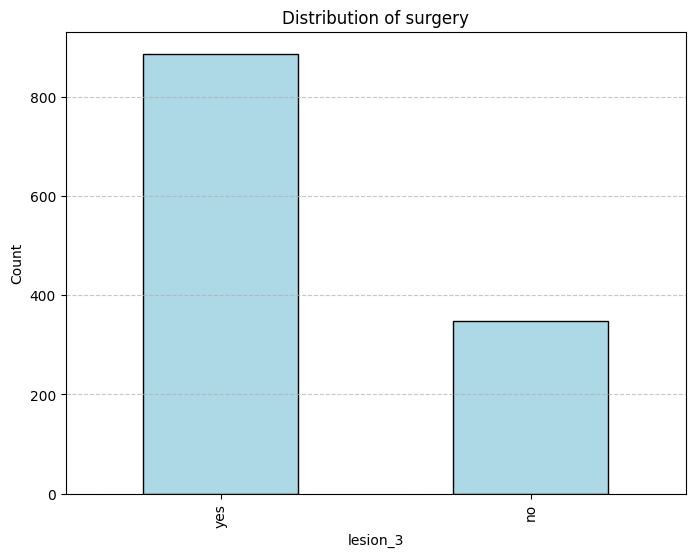

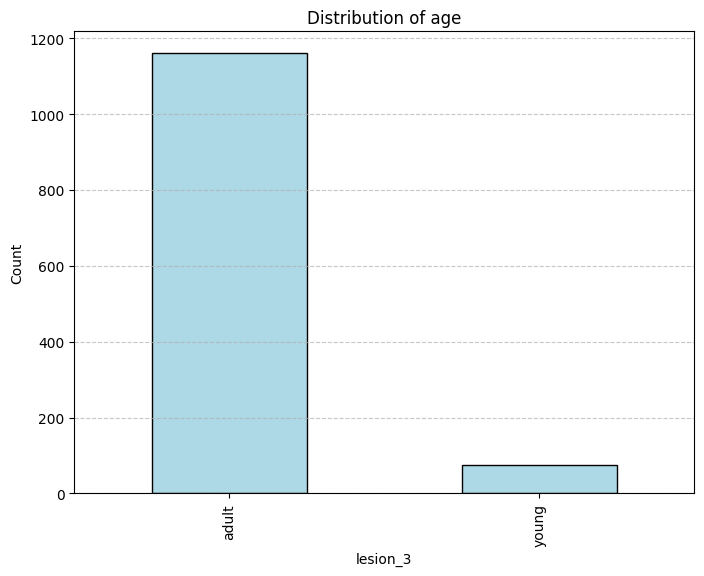

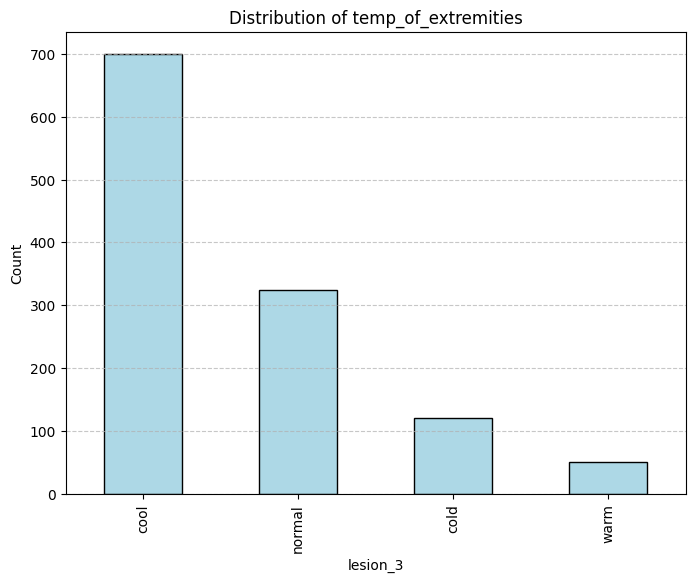

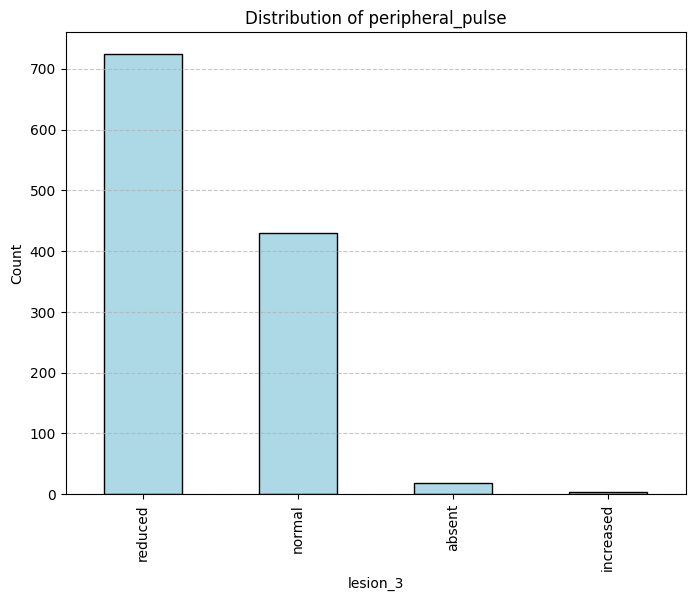

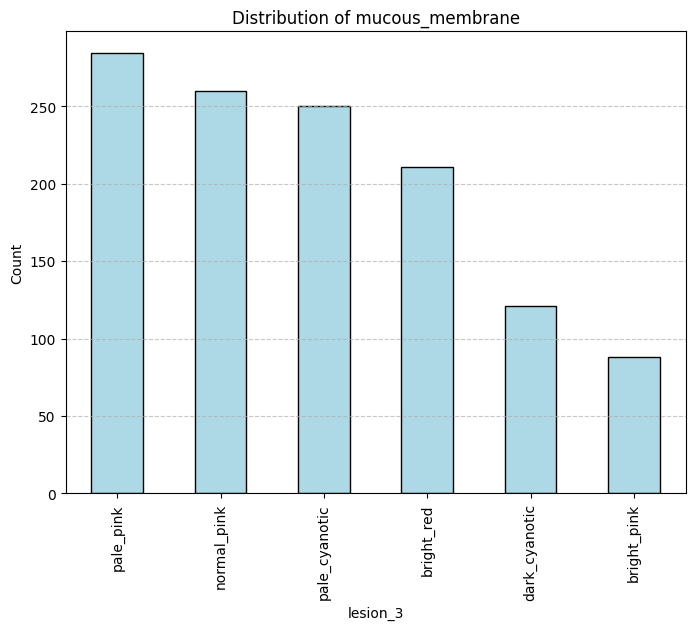

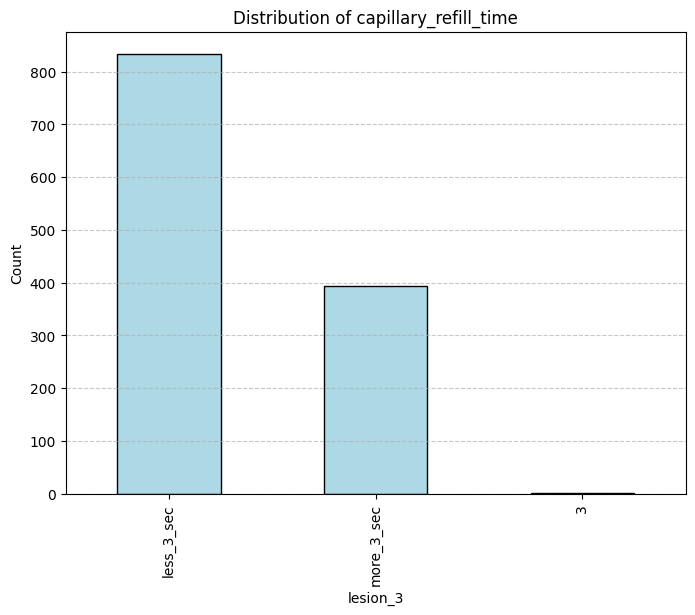

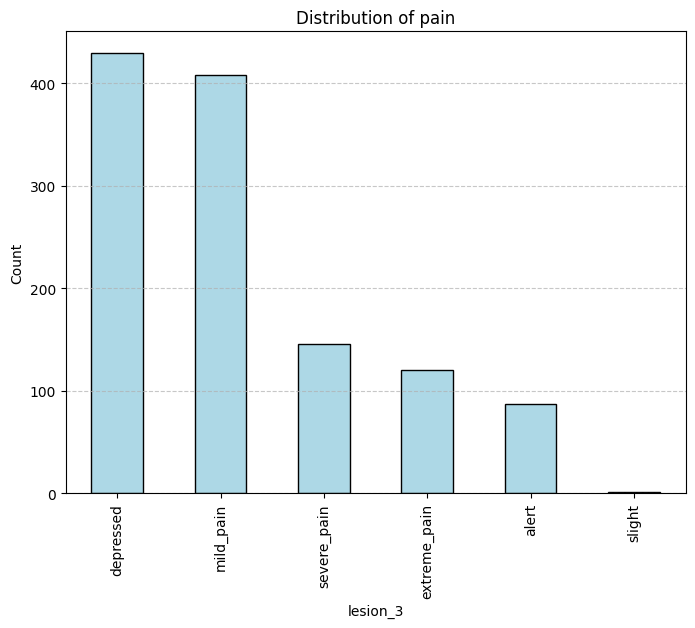

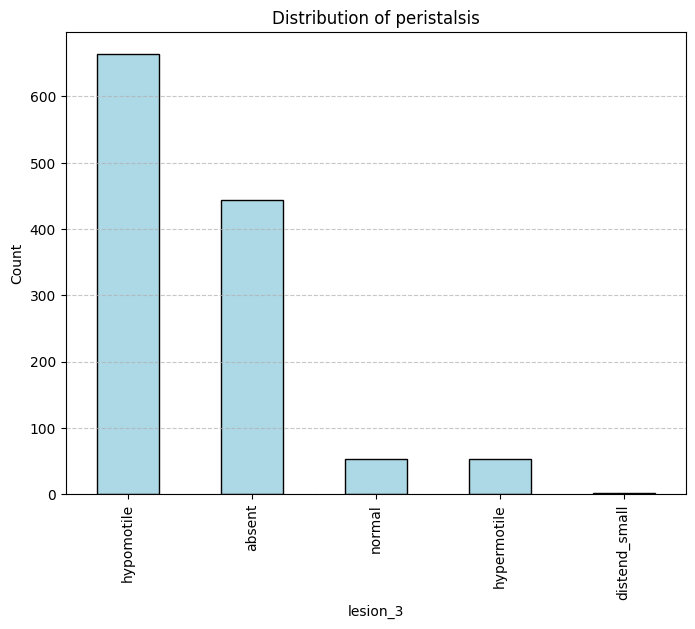

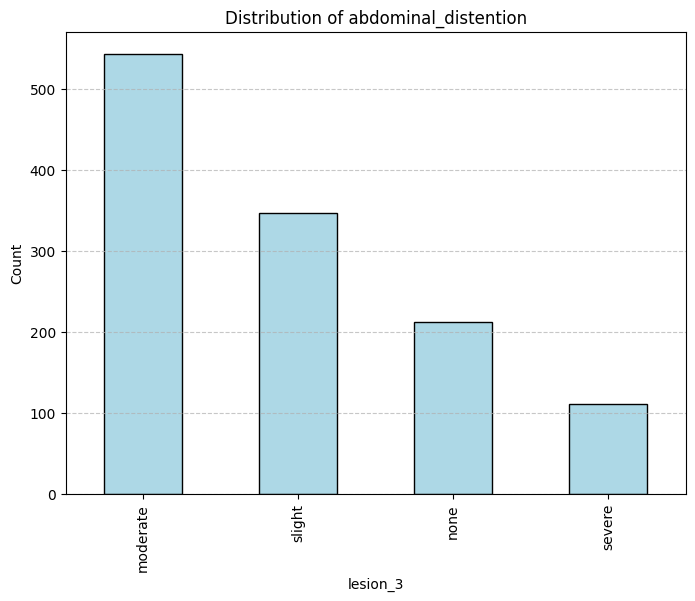

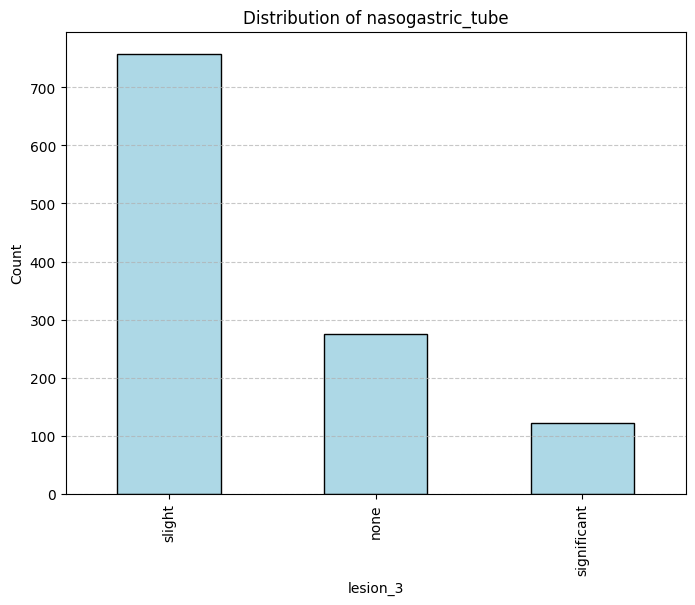

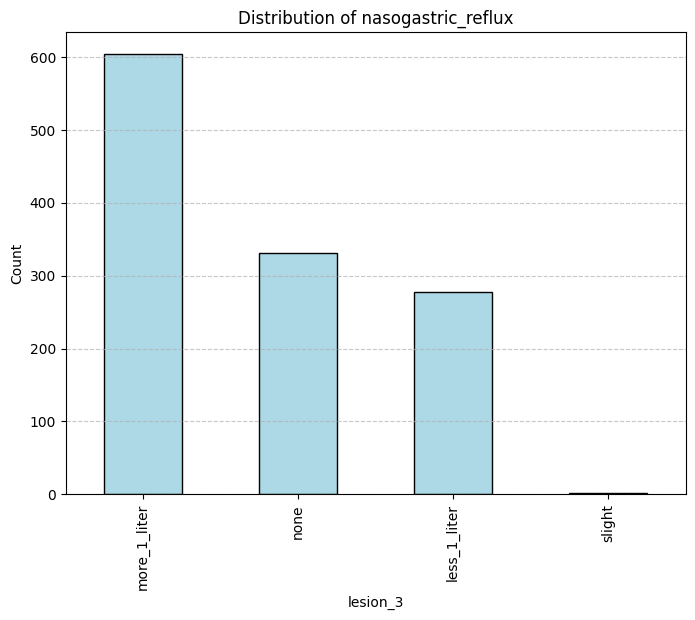

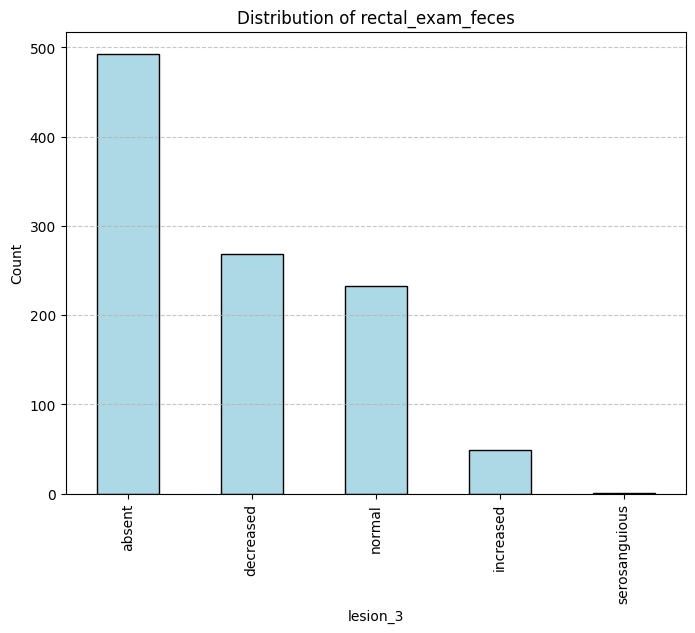

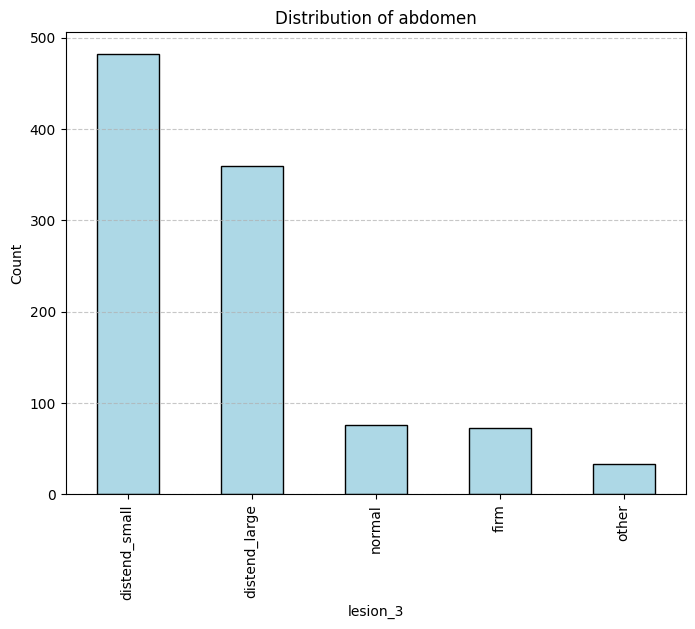

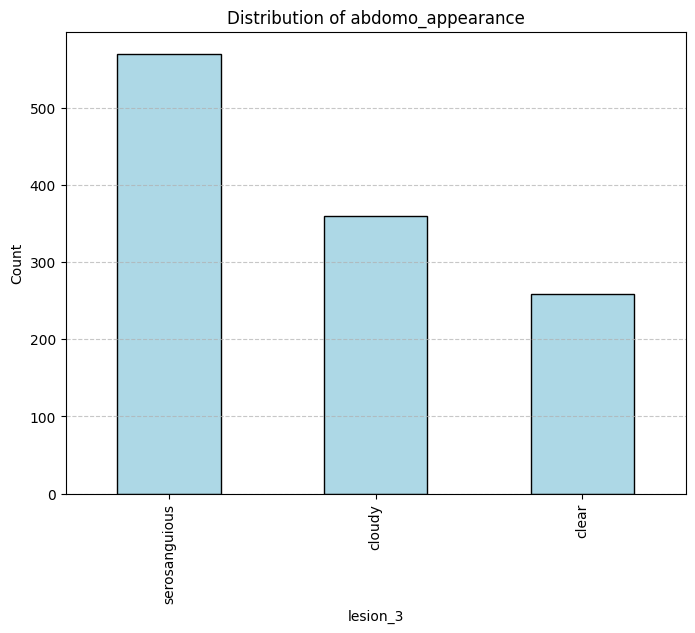

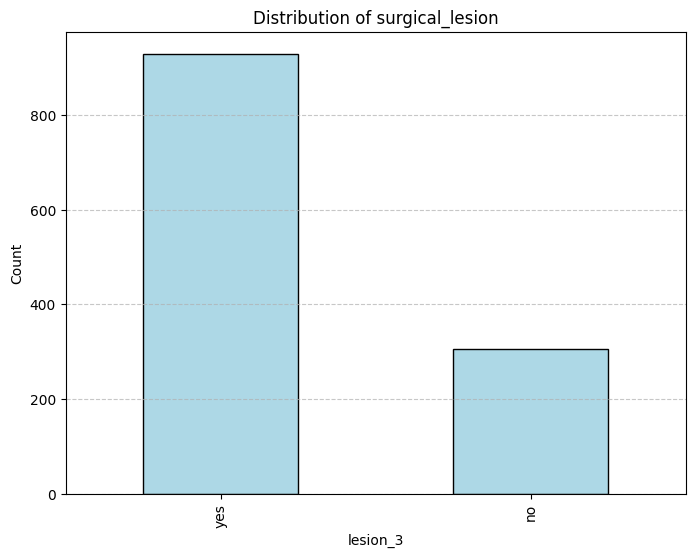

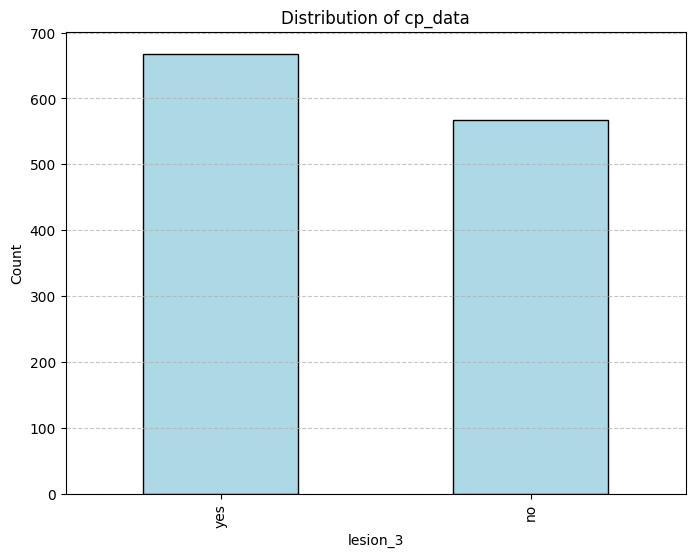

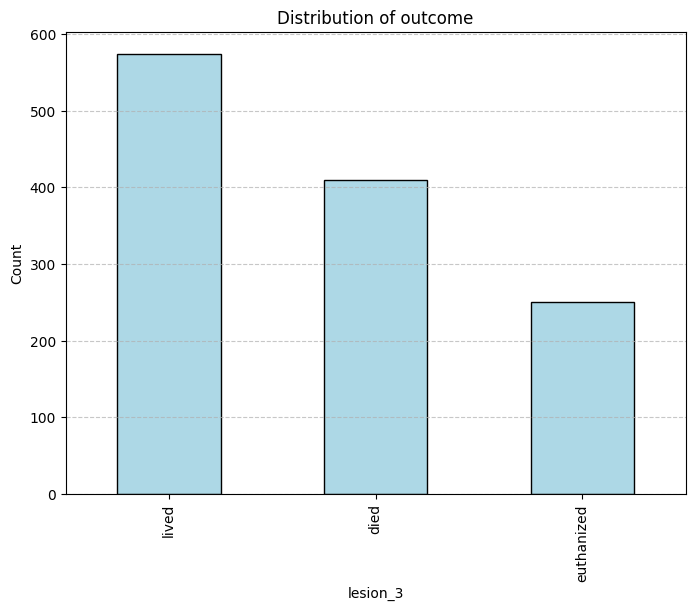

In [17]:
# creating bar charts for cat columns
for i in cat_cols:
    plt.figure(figsize=(8, 6))
    data[i].value_counts().plot(kind='bar', color='lightblue', edgecolor='black')
    plt.title(f"Distribution of {i}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

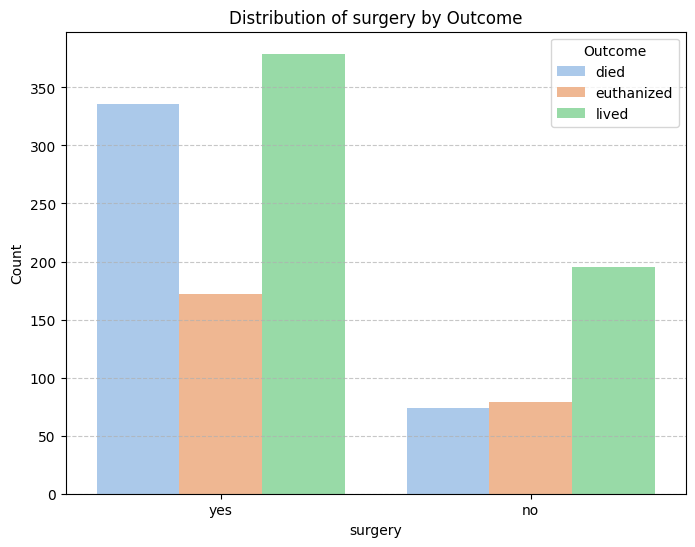

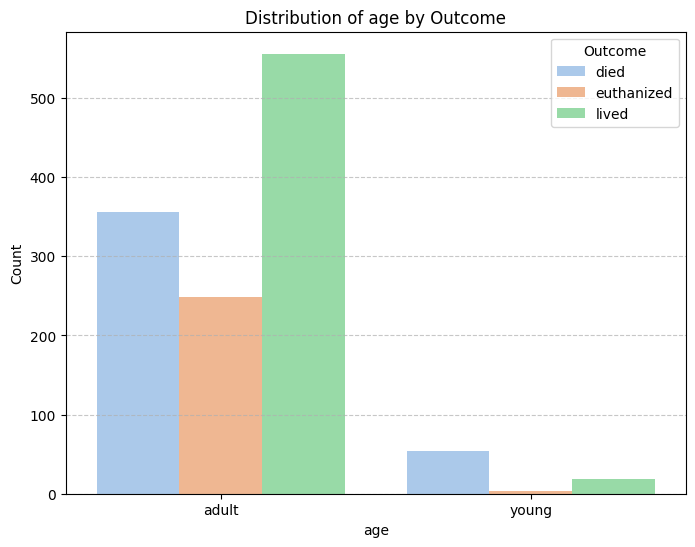

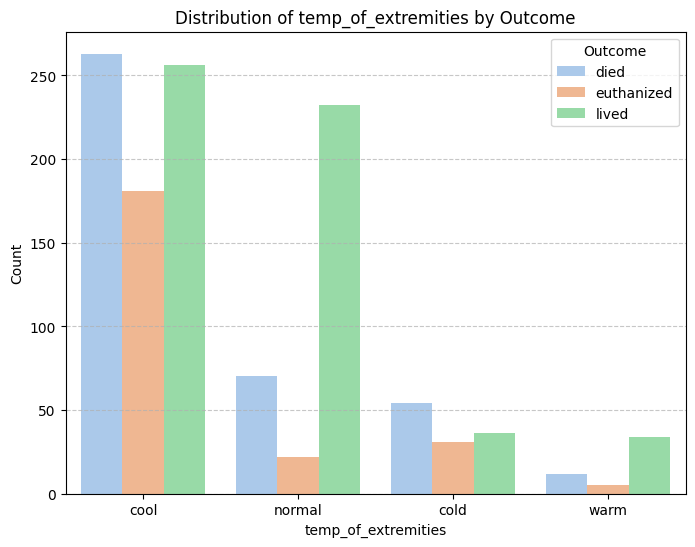

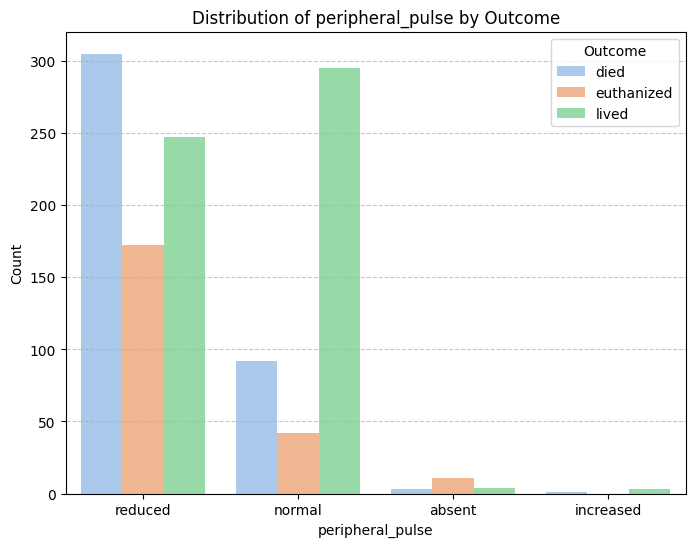

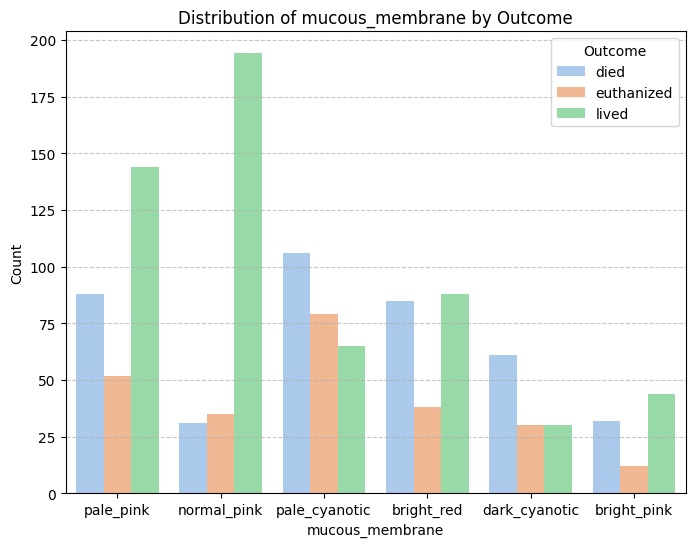

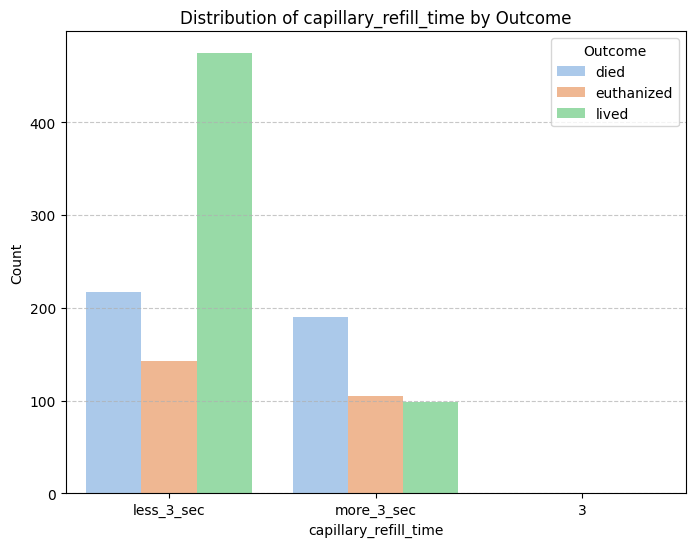

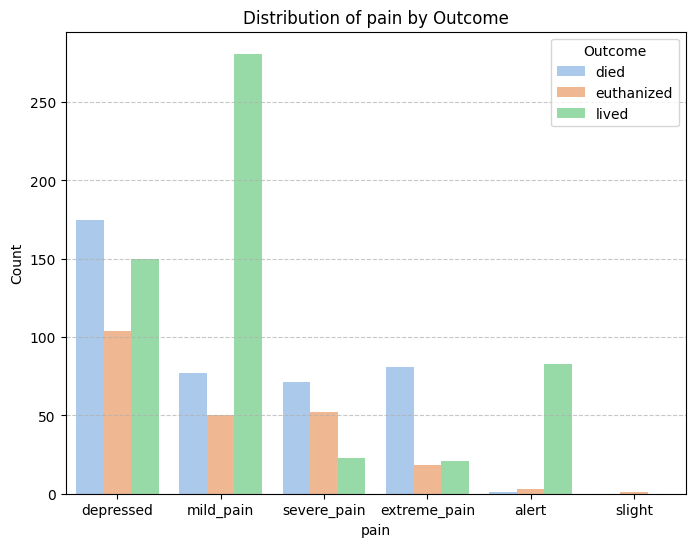

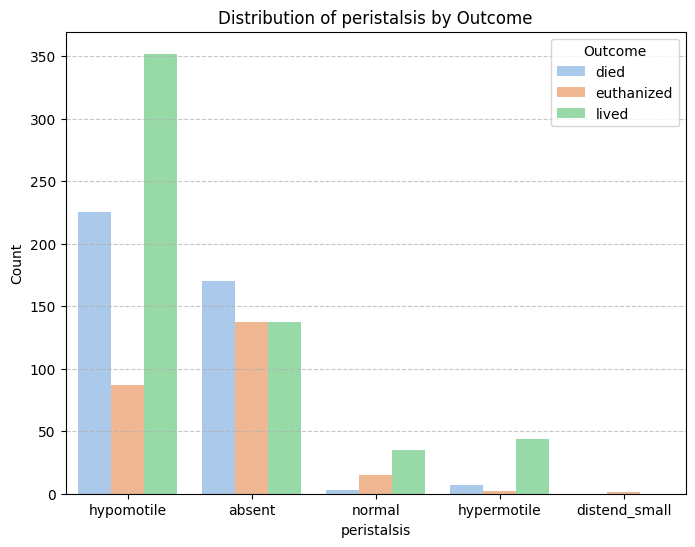

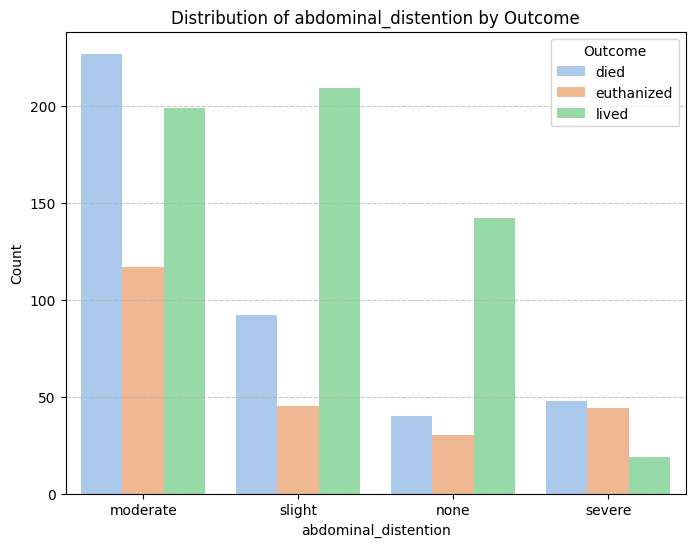

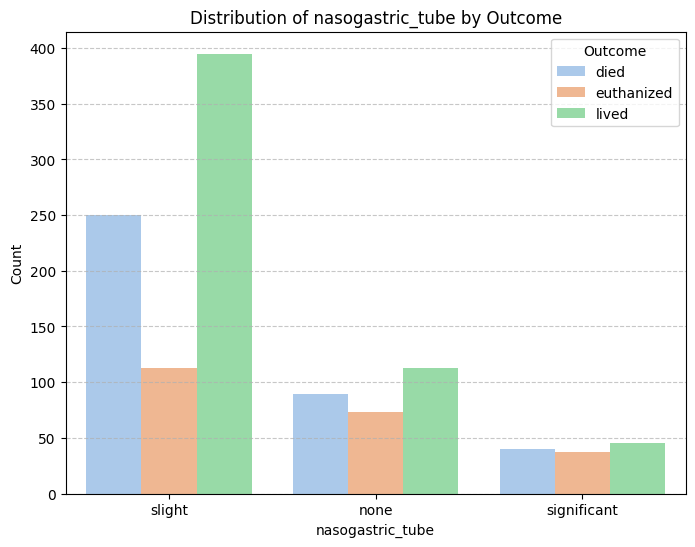

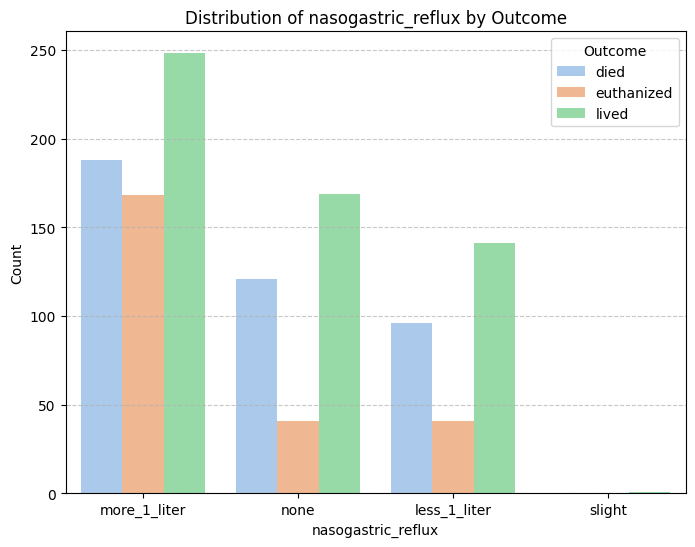

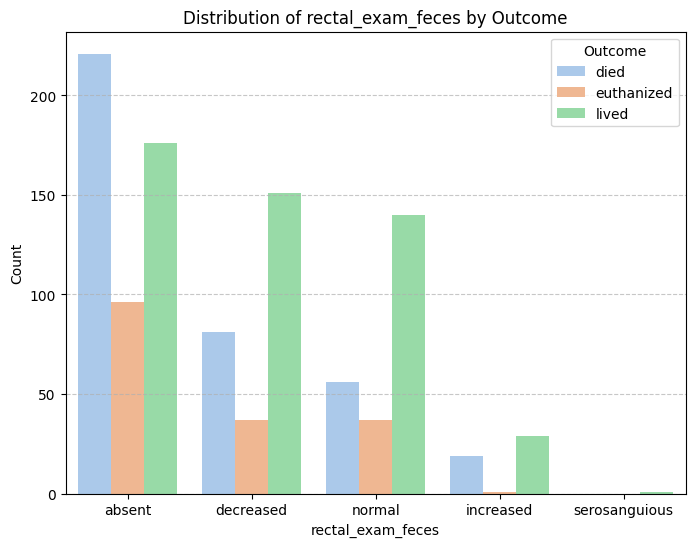

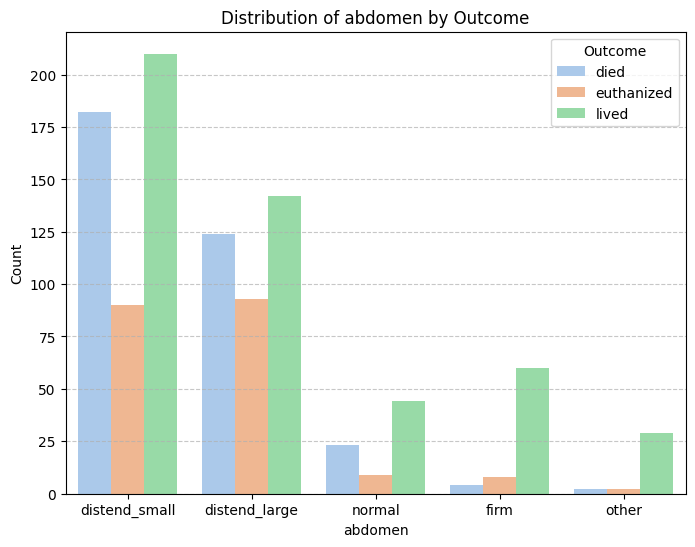

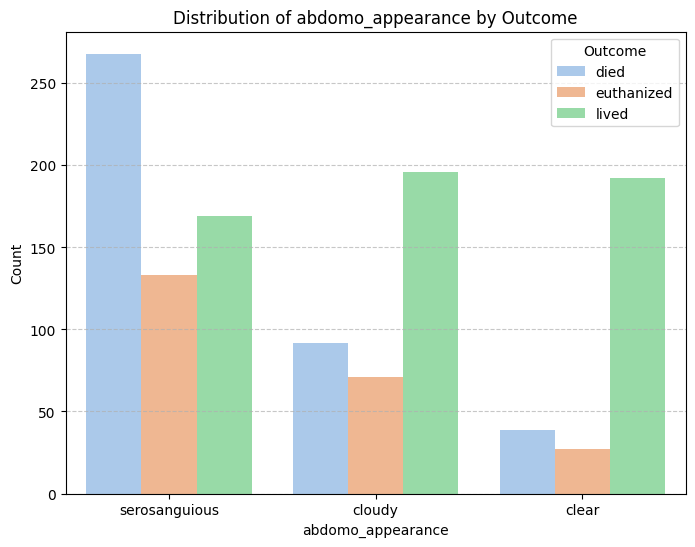

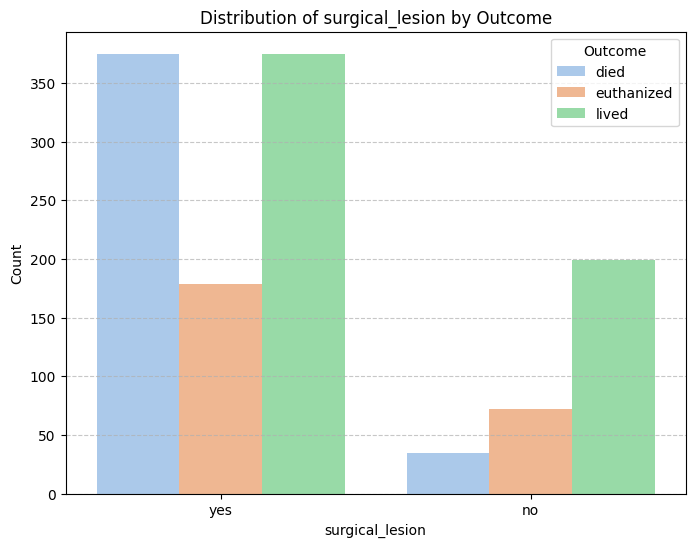

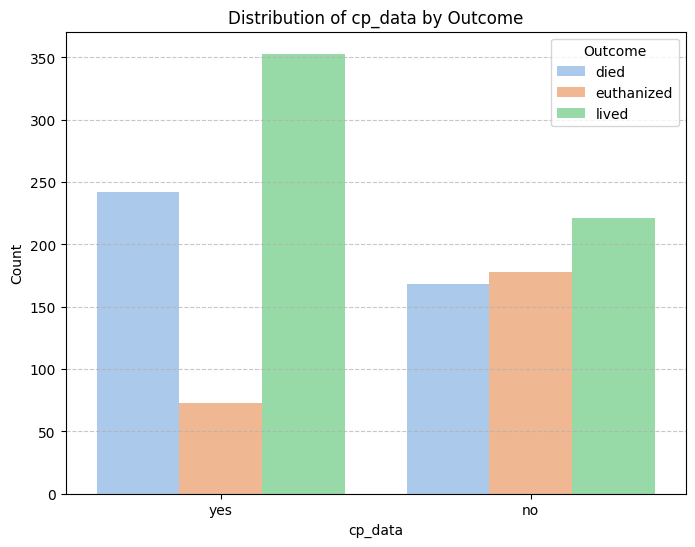

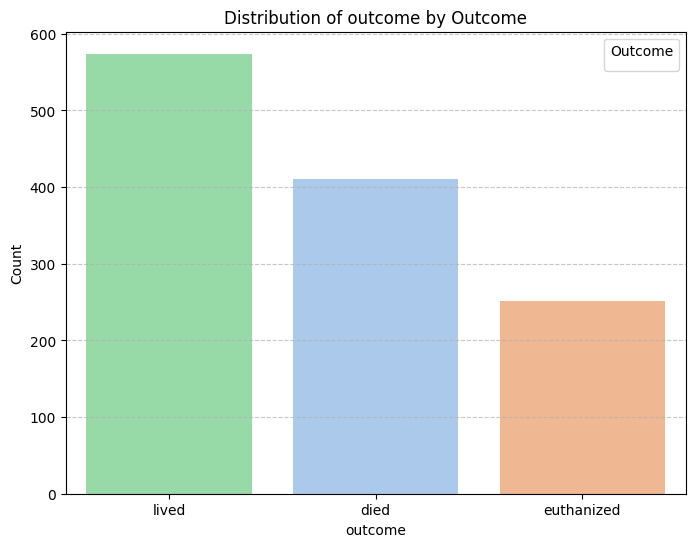

In [18]:
# creating barcharts to relate the cat features to the outcomes
for feature in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=feature, hue='outcome', order=data[feature].value_counts().index, palette='pastel')
    plt.title(f"Distribution of {feature} by Outcome")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title='Outcome')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

##Interpretting the Barcharts...

###**Sugery:**
Sugery seems to have a strong relationship with survival bc horses who has sugery seem to have a high chance of living. **USEFUL**

###**Age:**
The data is mostly made up of adult horses, and adult horeses mostly survived. Amoung the young horses, they were more likely to die. **LITTLE USEFUL**

###**Temp of Extremeties:**
This could be an strong predictor as cool is associated with more instances of death, while normal and warm are associated with better outcomes. **USEFUL**

###**Peripheral Pulse:**
This feature also seems to be a strong predictor. Instances of normal pulses have higher chance of survival and reduced or absent vice versa. **USEFUL**

###**Mucouse Membrane:**
Also seems to be a good predictor. normal pink seems to be a strong predictor of survival and pale/cyanotic not. **USEFUL**

###**Capillary refil time:**
Good predictor, delays in refill time are highly associated with death. **USEFUL**

###**Pain:**
Good predictor, mild pain is strongly linked to survival while higher pain levels are associated with mortality. **USEFUL**

###**Peristalsis:**
Strong predictor, normal/hypermotile are associated withy survival, while absent of hypomotile are assocaited with poor outcomes. **USEFUL**


###**Abdominal Distention:**
Moderate predictor, no distension is associated with survival, while severe is associated with poor outcomes. **LITTLE USEFUL**


###**Nasogastric Tube:**
Presence and severity may have moderator predicting power. Slight use is associated with better outcomes, while significant or absese dosen't. **USEFUL**


###**Nasogastric Reflux:**
Moderate predictor, higher volumes are linked to death, while none or lower volumes are linked to survival. **USEFUL**


###**Rectal Exam:**
Weak predictor, due to overlap, but could indicate poor outcomes if absent. **NOT USEFUL**


###**Abdomen:**
Weak predictor, a normal abdomen strongly indicates survival, but other categories are less distinct. **NOT USEFUL**


###**Abdomo Appearnce:**
Moderate predictor, serosanguinous appearance suggests death, while clear or cloudy appearance leans toward survival.
**USEFUL**

###**Surgical Lesion:**
Moderate predictor, an absence of surgical lesions is linked with better outcomes. ** LITTLE USEFUL**


###**CP data:**
Moderate predictor, 'yes' for cp_data seems to favor survival, while 'no' shows a more even distribution among the outcomes. ** LITTLE USEFUL**






---



####**After interpretting all the categoric features in relation to the outcomes that features that seems to be the strongest predictors are:**

*   Surgery
*   Abdomo Apearence
*   Capillary refill time
*   Pain
*   Temp of extremities


####**These next features didn't seem to be the strongest, but if my model isn't doing as well as I'd like, I will include these:**

*   Mucous Membrane
*   Peripheral Pulse
*   Nasogastric tube
*   Peristalsis
*   Nasogastric reflux
*   Age

####**Weak Predictors/Features i will not include in the model:**

*   Abdominal Distention
*   Rectal Exam Feces
*   Abdomen
*   Surgical Lesion  
*   CP data  

#After my Inital look and Visualization these are my plans...



---


The features I plan to include in my predictive models are:

    *   Rectal Temp
    *   Pulse
    *   Respiratory Rate
    *   Packed Cell Volume
    *   Surgery
    *   Abdomo Apearence
    *   Capillary refill time
    *   Pain
    *   Temp of extremities

This looks kind of extreme to get rid of so many features, but if my model does not perform well with only my strong predictors, I plan to also include the moderate predictors.

---


Since my dataset is mainly categorical, **I plan to use classfication models such as, Random Forest and XGBoost**.


---




**The evaluation metric i will use is F-1 score.** I chose this because I'm working on a multiclass classification problem, and my outcomes are slightly imbalanced. F-1 score treats all classes equally so it will be best in this situation.



